In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import matplotlib.pyplot as plt
import pattern.vis as vis
import sklearn.mixture as mix
import matplotsoccer as mps
import atomic.vaep as vaep

In [42]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions-one-action.h5")

In [43]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [44]:
with pd.HDFStore(spadl_h5) as spadlstore,\
    pd.HDFStore(predictions_h5) as predstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        p = predstore[f"game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        assert len(a) == len(p)
        a = pd.concat([a,p],axis=1)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]
actions = pd.concat([actions,vaep.value(actions,actions.scores,actions.concedes)],axis=1)

380it [00:13, 28.26it/s]


In [9]:
actions["logvalue"] = np.log(actions.scores / actions.concedes)

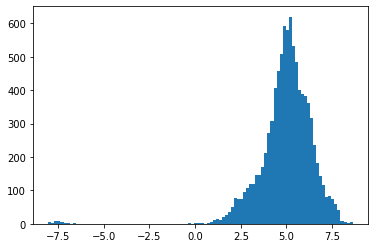

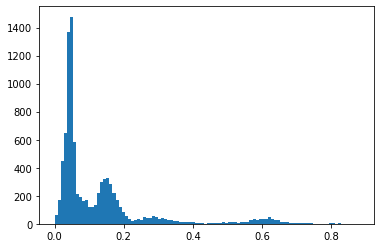

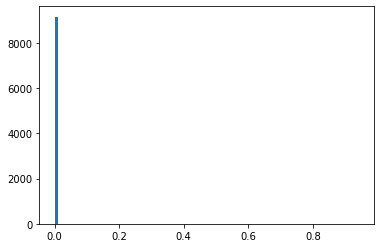

game_id  period_id  action_id  time_seconds     timestamp  team_id  \
158      14562.0        1.0        158         319.0  00:05:19.543     58.0   
266      14562.0        1.0        266         580.0  00:09:40.188     58.0   
427      14562.0        1.0        427         904.0  00:15:04.089     46.0   
477      14562.0        1.0        477        1038.0  00:17:18.572     46.0   
626      14562.0        1.0        626        1369.0  00:22:49.195     46.0   
...          ...        ...        ...           ...           ...      ...   
1188453  14650.0        2.0       3414        2400.0  00:40:00.349     37.0   
1188497  14650.0        2.0       3458        2460.0  00:41:00.117     55.0   
1188527  14650.0        2.0       3488        2503.0  00:41:43.298     37.0   
1188616  14650.0        2.0       3577        2656.0  00:44:16.956     37.0   
1188618  14650.0        2.0       3579        2659.0  00:44:19.139     37.0   

         player_id           x          y         dx         dy  type_id  \
158         5515.0   97.058824  36.151899   7.058824  -0.602532       11   
266        11288.0   97.941176  35.291139   1.764706  -0.860759       11   
427         9929.0   96.176471  28.405063   8.823529   8.951899       11   
477         5568.0   98.823529  39.594937   6.176471  -2.582278       11   
626         9934.0   96.176471  35.291139   1.764706 -14.632911       11   
...            ...         ...        ...        ...        ...      ...   
1188453     4041.0  102.970588  24.617722   2.029412   5.767089       11   
1188497    24938.0   91.676471  30.987342  12.088235   0.860759       11   
1188527     3076.0   88.852941  41.746835  16.147059 -10.329114       11   
1188616     4041.0   94.764706  44.156962   5.558824  -3.615190       11   
1188618     4041.0  102.617647  41.316456   2.382353 -10.415190       11   

         bodypart_id  is_home    scores  concedes type_name  offensive_value  \
158                0    False  0.163546  0.000924      shot         0.057277   
266                1    False  0.244369  0.002448      shot         0.146155   
427                0     True  0.132828  0.000209      shot         0.033553   
477                0     True  0.151227  0.000713      shot         0.047437   
626                0     True  0.097062  0.002361      shot        -0.016770   
...              ...      ...       ...       ...       ...              ...   
1188453            0    False  0.055592  0.000159      shot         0.023606   
1188497            0     True  0.117060  0.000199      shot         0.073351   
1188527            0    False  0.036404  0.000371      shot         0.001623   
1188616            0    False  0.177074  0.000317      shot         0.147183   
1188618            0    False  0.119544  0.000282      shot         0.089162   

         defensive_value  vaep_value  
158            -0.000431    0.056846  
266            -0.002088    0.144067  
427            -0.000088    0.033465  
477            -0.000495    0.046942  
626            -0.002026   -0.018796  
...                  ...         ...  
1188453         0.000065    0.023671  
1188497         0.000045    0.073396  
1188527        -0.000187    0.001436  
1188616        -0.000180    0.147003  
1188618        -0.000012    0.089150  

[9199 rows x 20 columns]

In [51]:
a = actions[actions.type_name == "shot"]
plt.hist(np.log(a.scores / a.concedes),bins=100)
plt.show()
plt.hist(a.scores,bins=100)
plt.show()
plt.hist(a.concedes,bins=100)
plt.show()
a

In [88]:
# Make a nice action subset
import pattern.action as pat

a = actions[200000:400000].fillna(0)
a = actions.fillna(0)
a = pat.simplify(a)
#a["type_name"] = a.type_name.mask(~a.is_home,a.type_name + "_opp")
#a["x"] = a.x.mask(a.type_name=="goal",105)
#a["y"] = a.y.mask(a.type_name=="goal",32.5)
#a["dx"] = a.dx.mask(a.type_name=="shot",105-a.x)
#a["dy"] = a.dy.mask(a.type_name=="shot",32.5-a.y)
len(a)

1188670

In [36]:
candidates2 = pat.candidates(a,["x","y",
                               #"dx","dy",
                               "logvalue"],25,True)

Training shot_penalty components:  58%|█████▊    | 11/19 [00:00<00:00, 109.43it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_iter=True)
Training shot_penalty components:  89%|████████▉ | 17/19 [00:00<00:00, 69.19it/s] /home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return_n_iter=True)
Training clearance components: 100%|██████████| 25/25 [00:05<00:00,  4.69i

In [89]:
from sklearn.decomposition import PCA,NMF

cols = ["x","y","dx","dy","scores","concedes"]
for i in range(1,5):
    pca = PCA(n_components=i)
    pca.fit(a[cols])
    print(i,sum(pca.explained_variance_ratio_))

1 0.5240195895397621
2 0.8564458382452556
3 0.9405716902547792
4 0.9999989046430195


In [67]:
pd.DataFrame(pca.components_,columns=cols)

x            y           dx          dy     scores  concedes
0 -8796.535242 -2772.199111  -158.862761    0.000000 -13.486432  0.000000
1     0.000000  -786.907937     0.000000  782.879781   0.000000  0.000000
2     0.000000     0.000000 -1056.093740    0.000000   2.662958  0.000000
3     0.000000  -517.891743     0.000000 -285.198633   0.019382 -0.121868

In [90]:
candidates6 = pat.candidates(a,["x","y",
                               "dx","dy",
                               "scores",
                                "concedes"
                               ],25,True)

Training clearance components: 100%|██████████| 25/25 [00:43<00:00,  1.73s/it]


In [11]:
#ac = a[a.type_name.isin(["cross","corner","throw_in","shot"])]
candidates = pat.candidates(a,["x","y","dx","dy","logvalue"],25,True)
lns = {t : len(a[a.type_name==t]) for t in set(a.type_name)}

Training clearance components: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]


In [12]:
list((m.n_components,s) for t,m,s in candidates if t == "shot")

[(1, 5798.803612130438),
 (2, 5995.668702580555),
 (3, 6231.0267573682095),
 (4, 6333.851092865188),
 (5, 6465.885641827218),
 (6, 6597.694626392762),
 (7, 6614.14036944235),
 (8, 6650.182320696481),
 (9, 6687.589987610207),
 (10, 6698.512886978569),
 (11, 6726.970269840485),
 (12, 6739.104661457353),
 (13, 6764.978306225294),
 (14, 6767.044478246364),
 (15, 6787.074088186832),
 (16, 6804.021395384441),
 (17, 6843.7303184505145),
 (18, 6816.474696093614),
 (19, 6848.225790907183),
 (20, 6871.025846435783),
 (21, 6884.5644848999145),
 (22, 6888.179977403763),
 (23, 6920.698245231804),
 (24, 6972.570823385014),
 (25, 6923.783373715231)]

In [38]:
#import np.linalg
def covarnorm(gmm):
    covars = gmm.covariances_
    s = 0
    for i in range(len(covars)):
        s += np.linalg.norm(np.diag(covars[i]))
    return s/len(covars)

In [77]:
candidates6

[('foul',
  GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                  means_init=None, n_components=1, n_init=1, precisions_init=None,
                  random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                  verbose_interval=10, warm_start=False, weights_init=None),
  14133.553373878072),
 ('foul',
  GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                  means_init=None, n_components=2, n_init=1, precisions_init=None,
                  random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                  verbose_interval=10, warm_start=False, weights_init=None),
  18050.84668774109),
 ('foul',
  GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                  means_init=None, n_components=3, n_init=1, precisions_init=None,
                  random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                  verbose_interval=10, warm_start=False, wei

In [94]:
#list((m.n_components,s) for t,m,s in normcandidates if t=="shot")
ov = a.groupby("type_name")[["concedes","scores"]].sum()
ov["combined"] = abs(ov.scores-ov.concedes)
ov = dict(ov.combined)
ov

{'bad_touch': 29.102924593011267,
 'clearance': 106.01748326549932,
 'corner': 108.7447748010236,
 'cross': 289.93490501135966,
 'dribble': 2232.8906333290342,
 'foul': 134.72315743033687,
 'freekick': 55.50123266305309,
 'goal': 1039.3134528037554,
 'goalkick': 2.7779381993459538,
 'interception': 94.51982888823841,
 'keeper_catch': 96.3044392370357,
 'offside': 9.146753060071205,
 'out': 7.416773818782531,
 'owngoal': 28.07487195212161,
 'pass': 1576.2562665513615,
 'receival': 2117.8327536761954,
 'red_card': 0.07013130614359397,
 'shot': 1131.7752553260798,
 'shot_penalty': 62.007853451301344,
 'tackle': 0.5055104135826696,
 'take_on': 158.57419213027606,
 'throw_in': 24.468132383302873,
 'yellow_card': 13.684996076990501}

In [97]:
import cvxpy as cp

n = 150

normcandidates = [(t,m,
                   s#*ov[t]#/lns[t]*np.log(lns[t])#tnp.log(lns[t])
                  ) for t,m,s in candidates6]# if t not in ["goal","shot_penalty"]]

# normcandidates = [(t,m,
#                    -covarnorm(m)#*(lns[t])
#                   ) for t,m,s in candidates]

selected_candidates = pat.ilp_select_candidates(normcandidates,n,verbose=False)

gmme = pat.GMMEnsemble(["x","y",
                               "dx","dy",
                               "scores",
                                "concedes"]
                       ,{k:m for k,m,s in selected_candidates})
gmme.components()

{'foul': 4,
 'interception': 22,
 'cross': 4,
 'goalkick': 2,
 'pass': 24,
 'freekick': 2,
 'red_card': 1,
 'throw_in': 3,
 'out': 10,
 'bad_touch': 3,
 'shot': 7,
 'owngoal': 1,
 'receival': 21,
 'yellow_card': 2,
 'dribble': 15,
 'corner': 4,
 'shot_penalty': 1,
 'take_on': 5,
 'tackle': 4,
 'keeper_catch': 2,
 'goal': 1,
 'offside': 1,
 'clearance': 11}

In [18]:
np.argsort([3,2])

array([1, 0])

bad_touch 3 9472


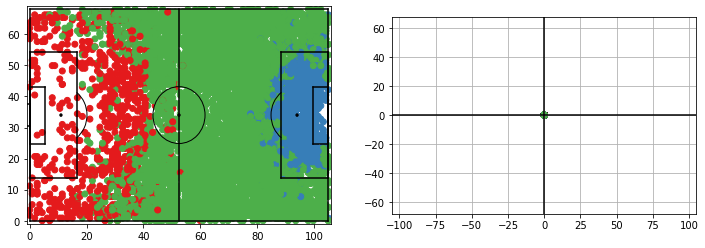

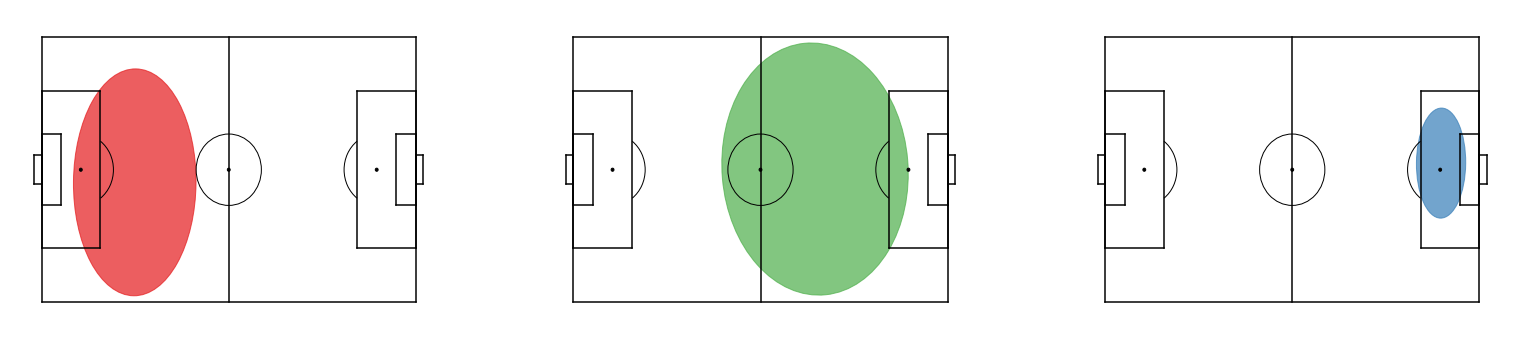

clearance 11 18135


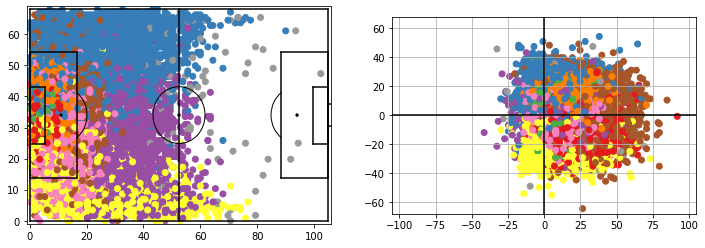

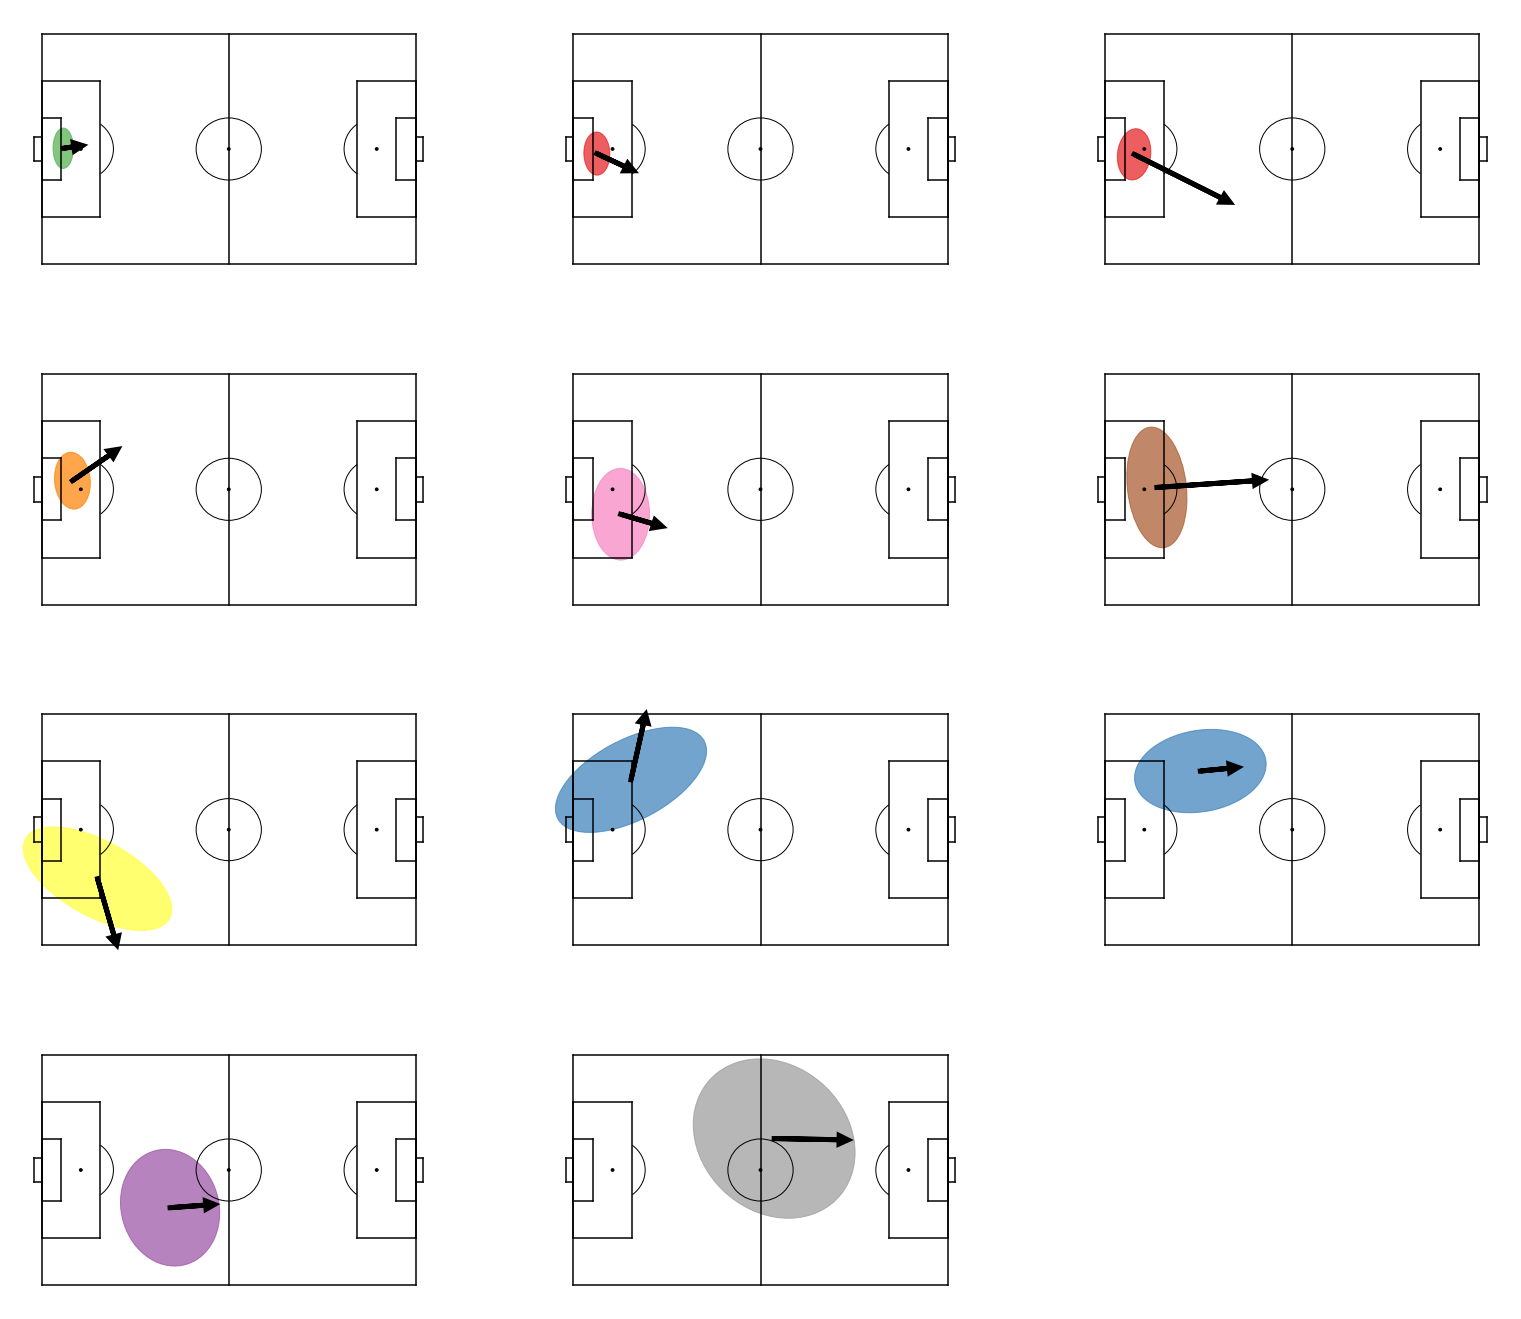

corner 4 3882


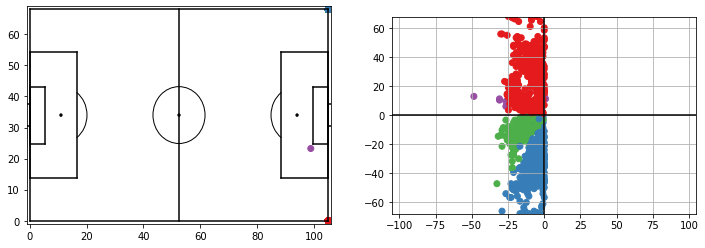

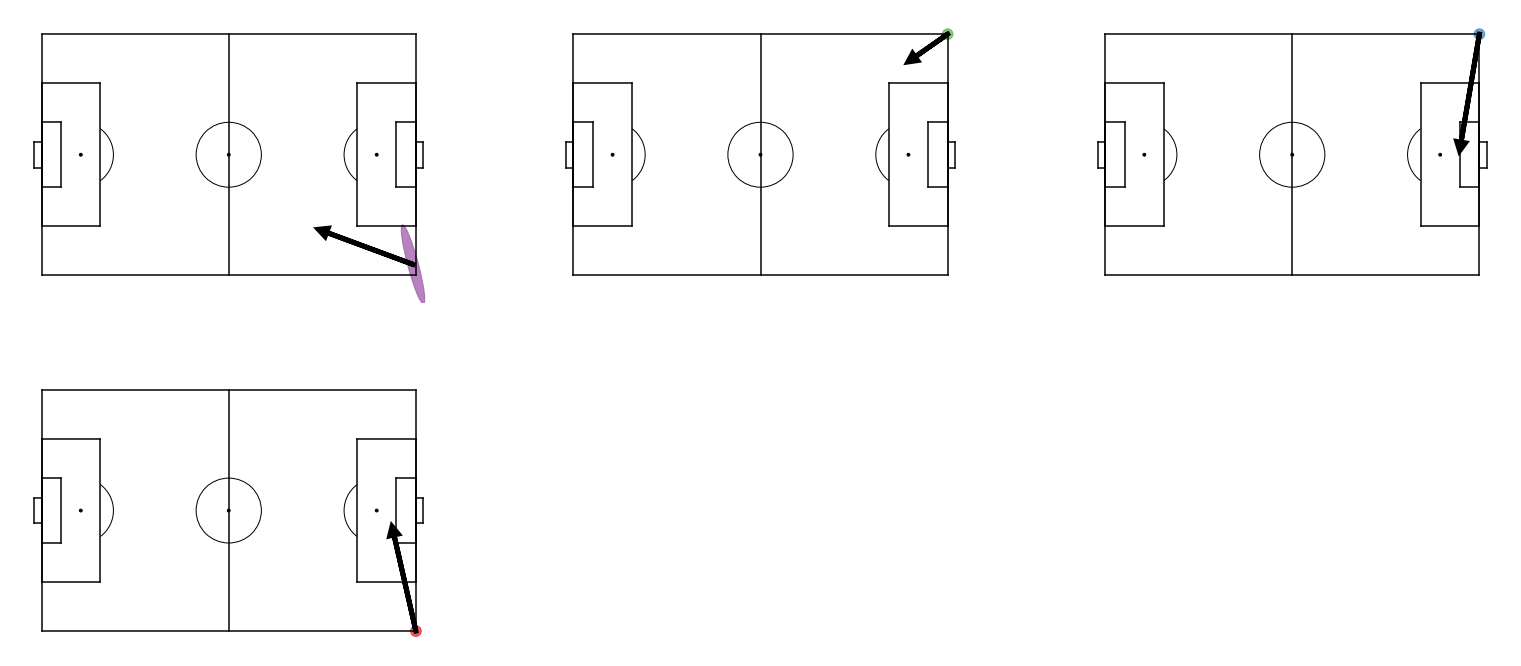

cross 4 8284


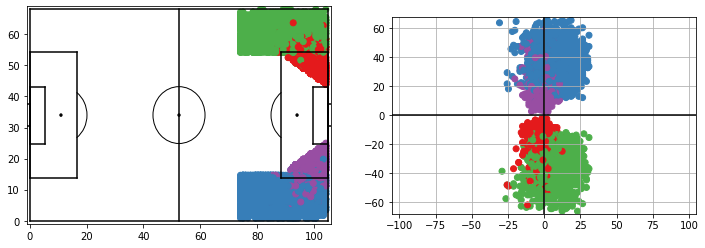

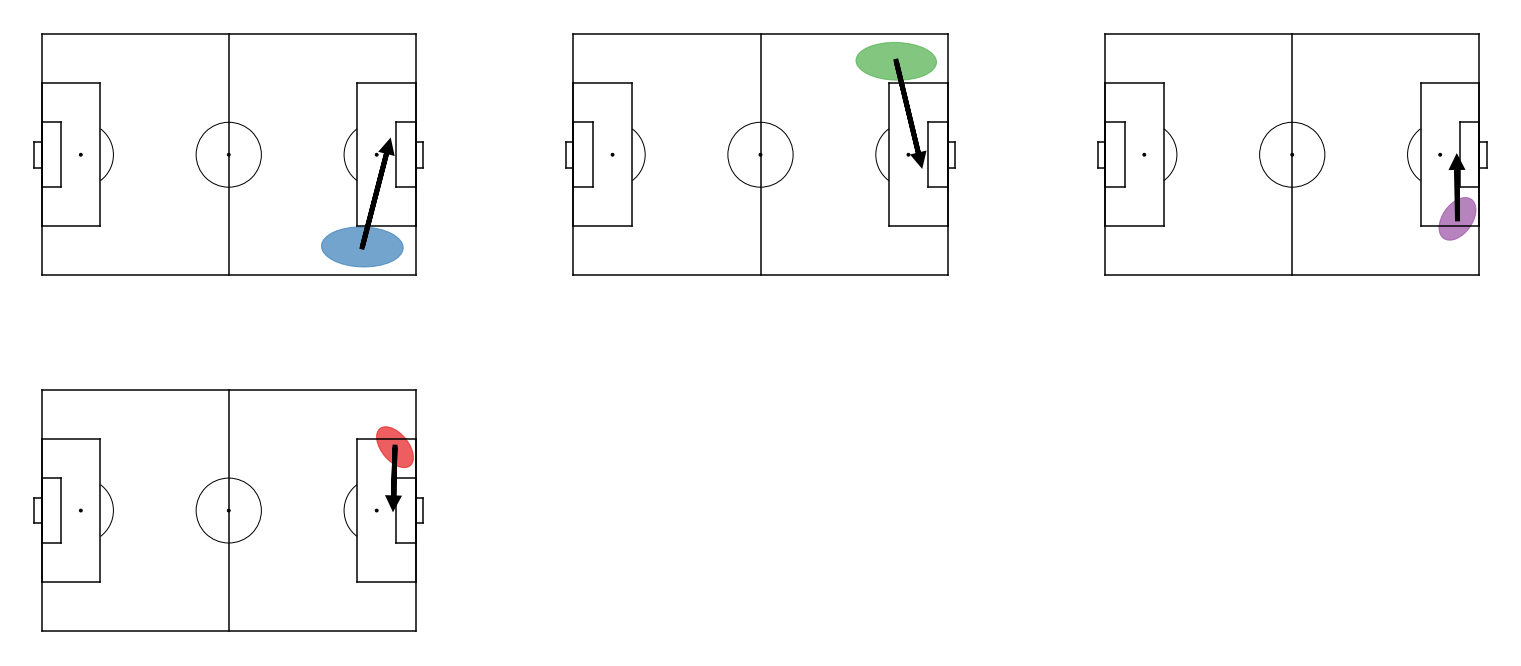

dribble 15 333194


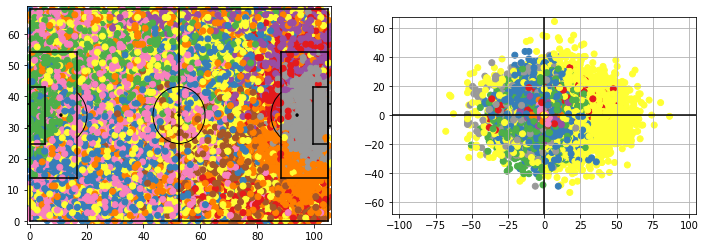

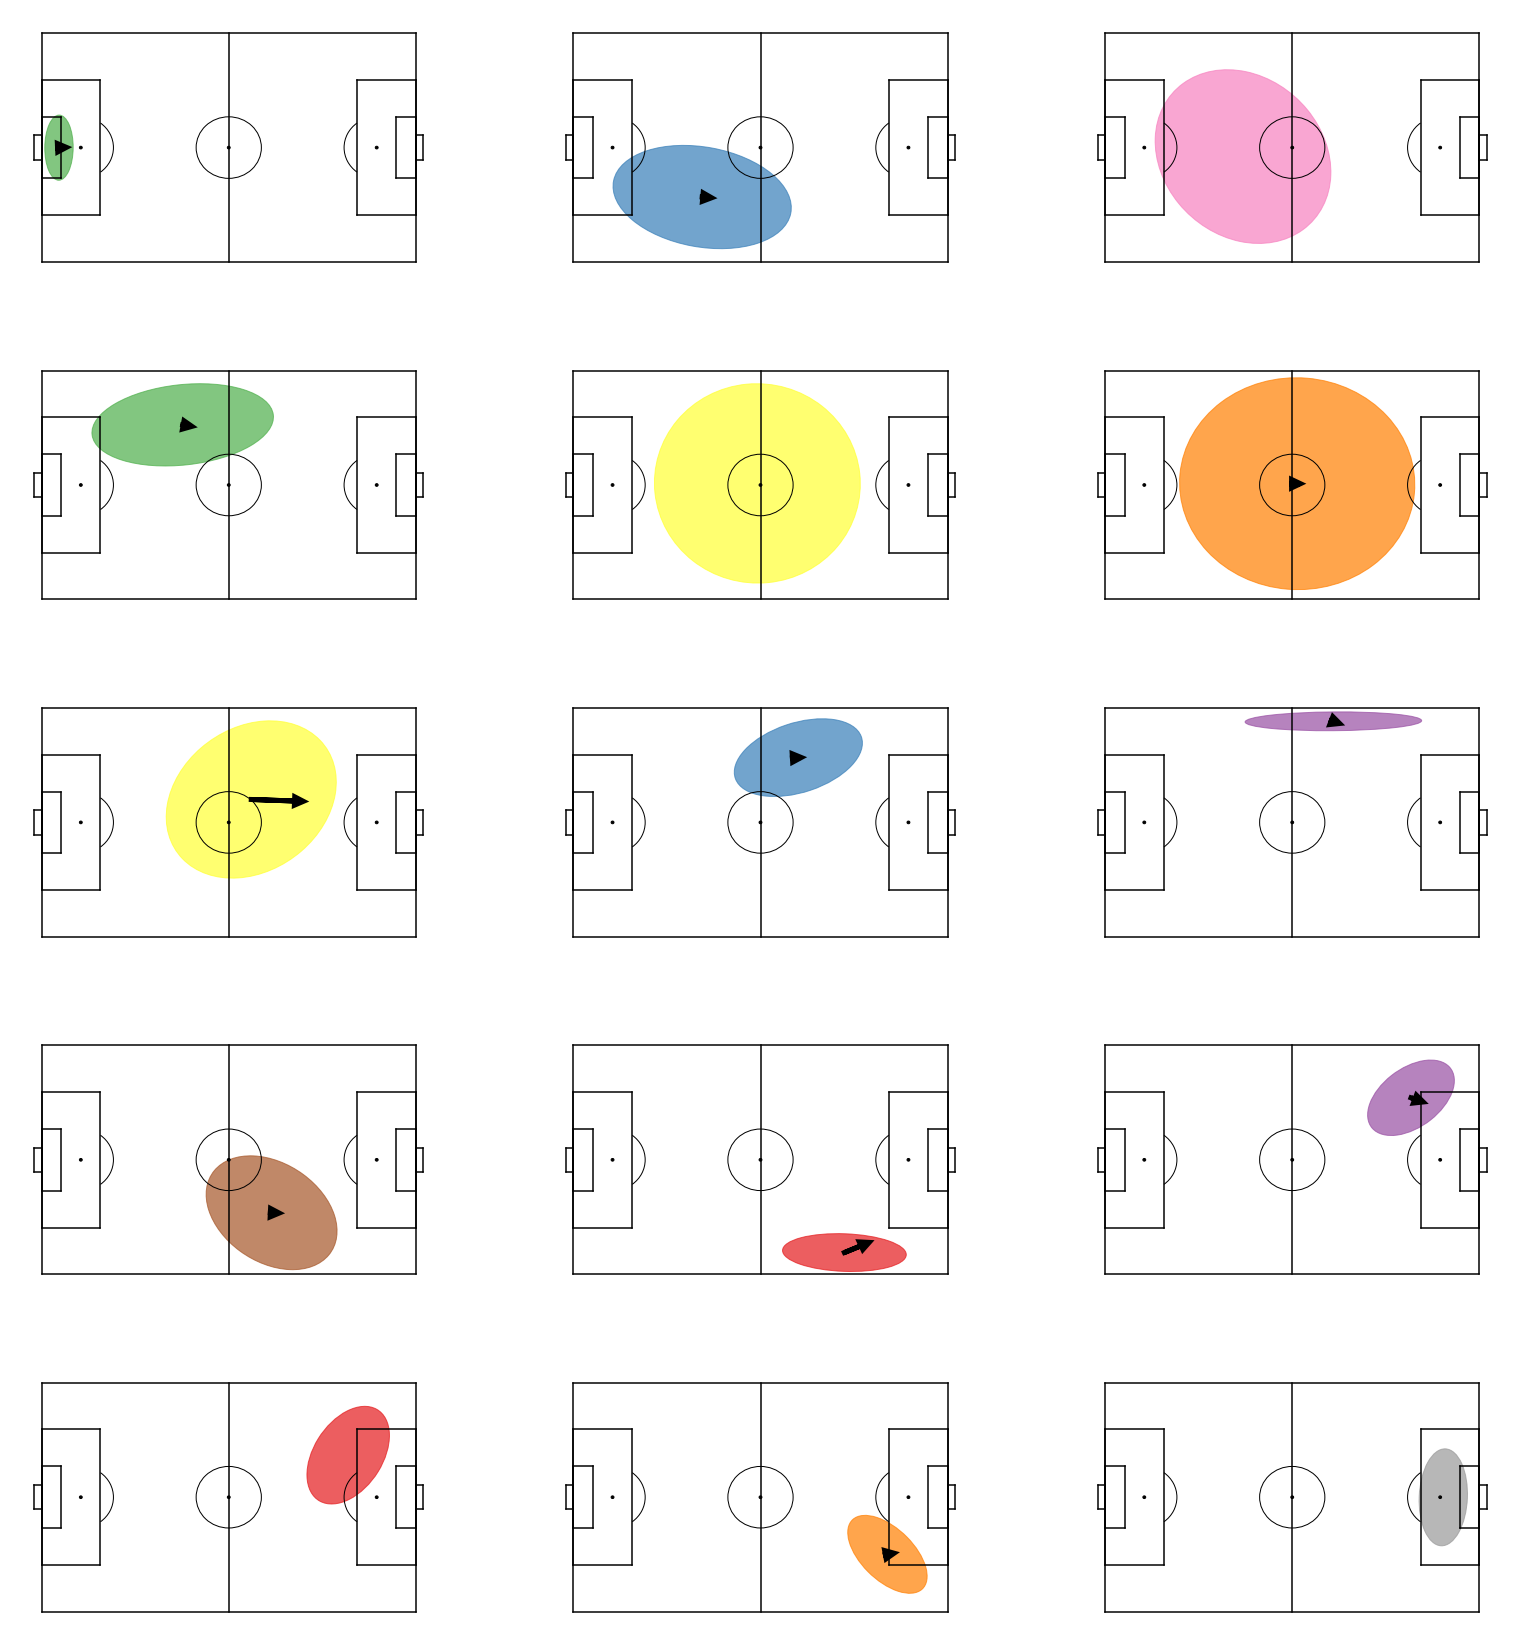

foul 4 8924


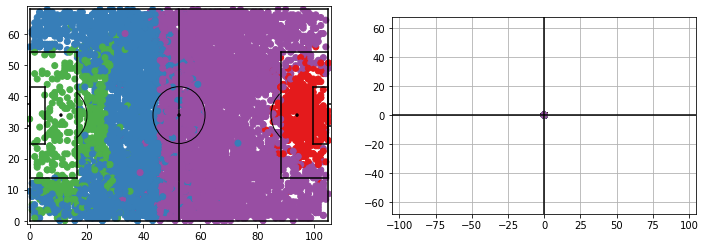

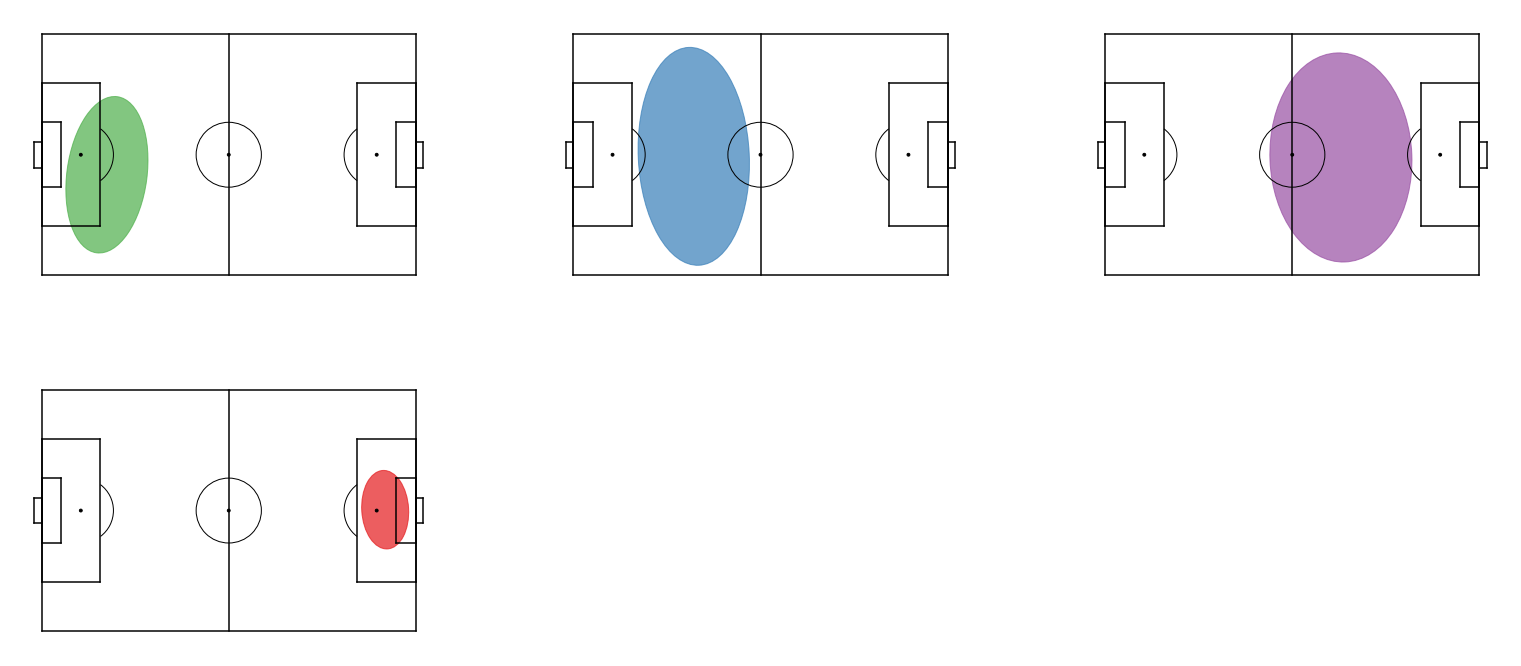

freekick 2 8839


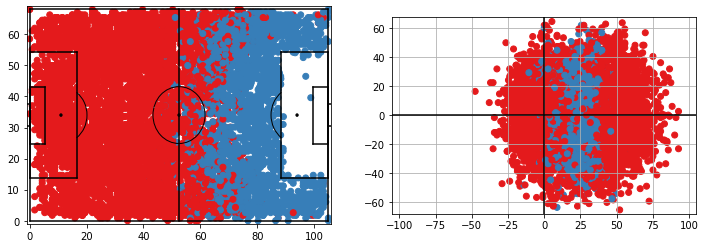

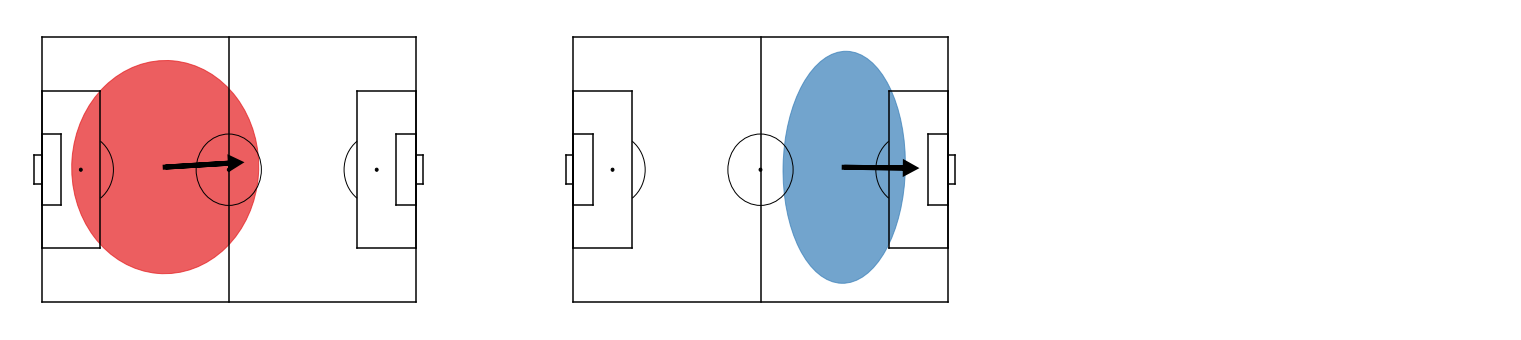

goal 1 1040


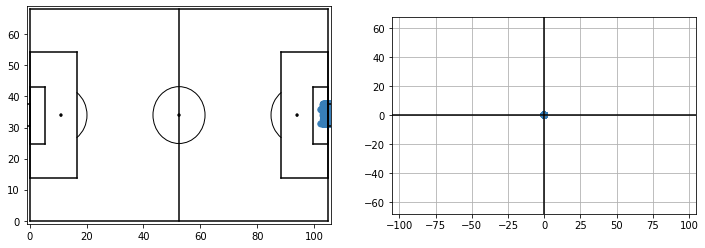

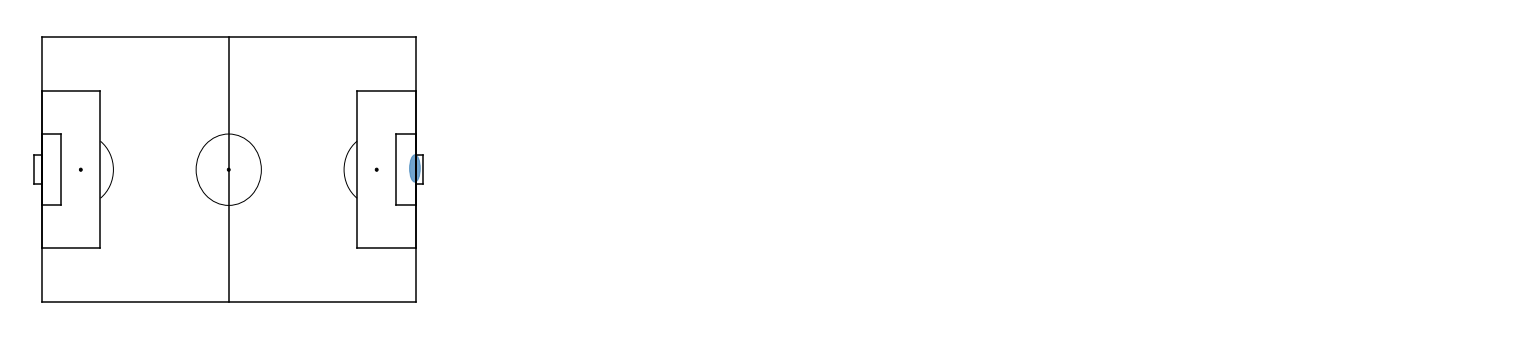

goalkick 2 5834


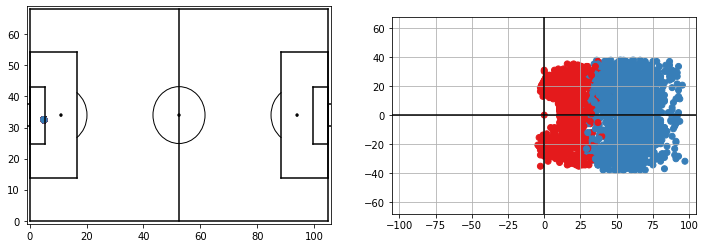

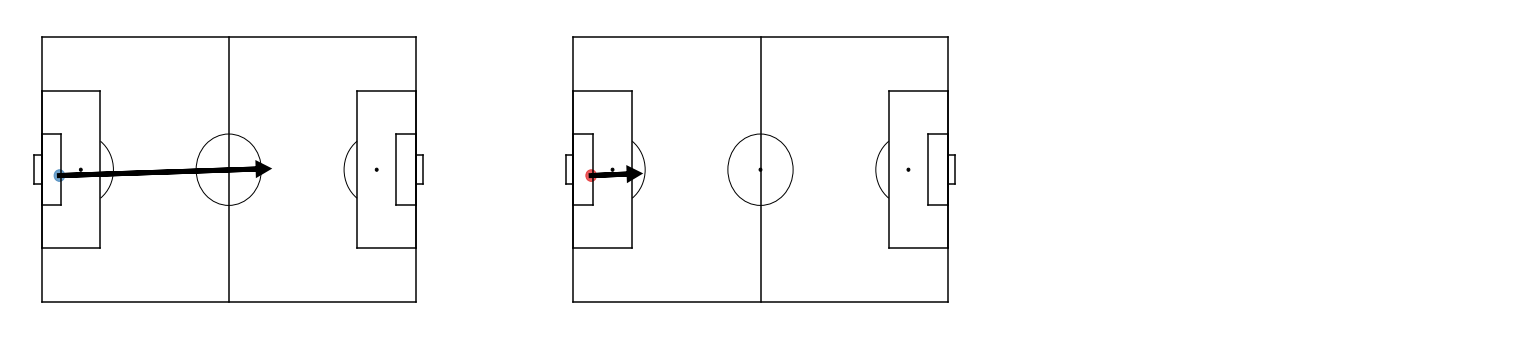

interception 22 73991


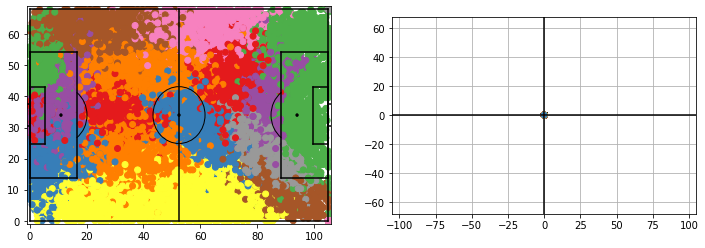

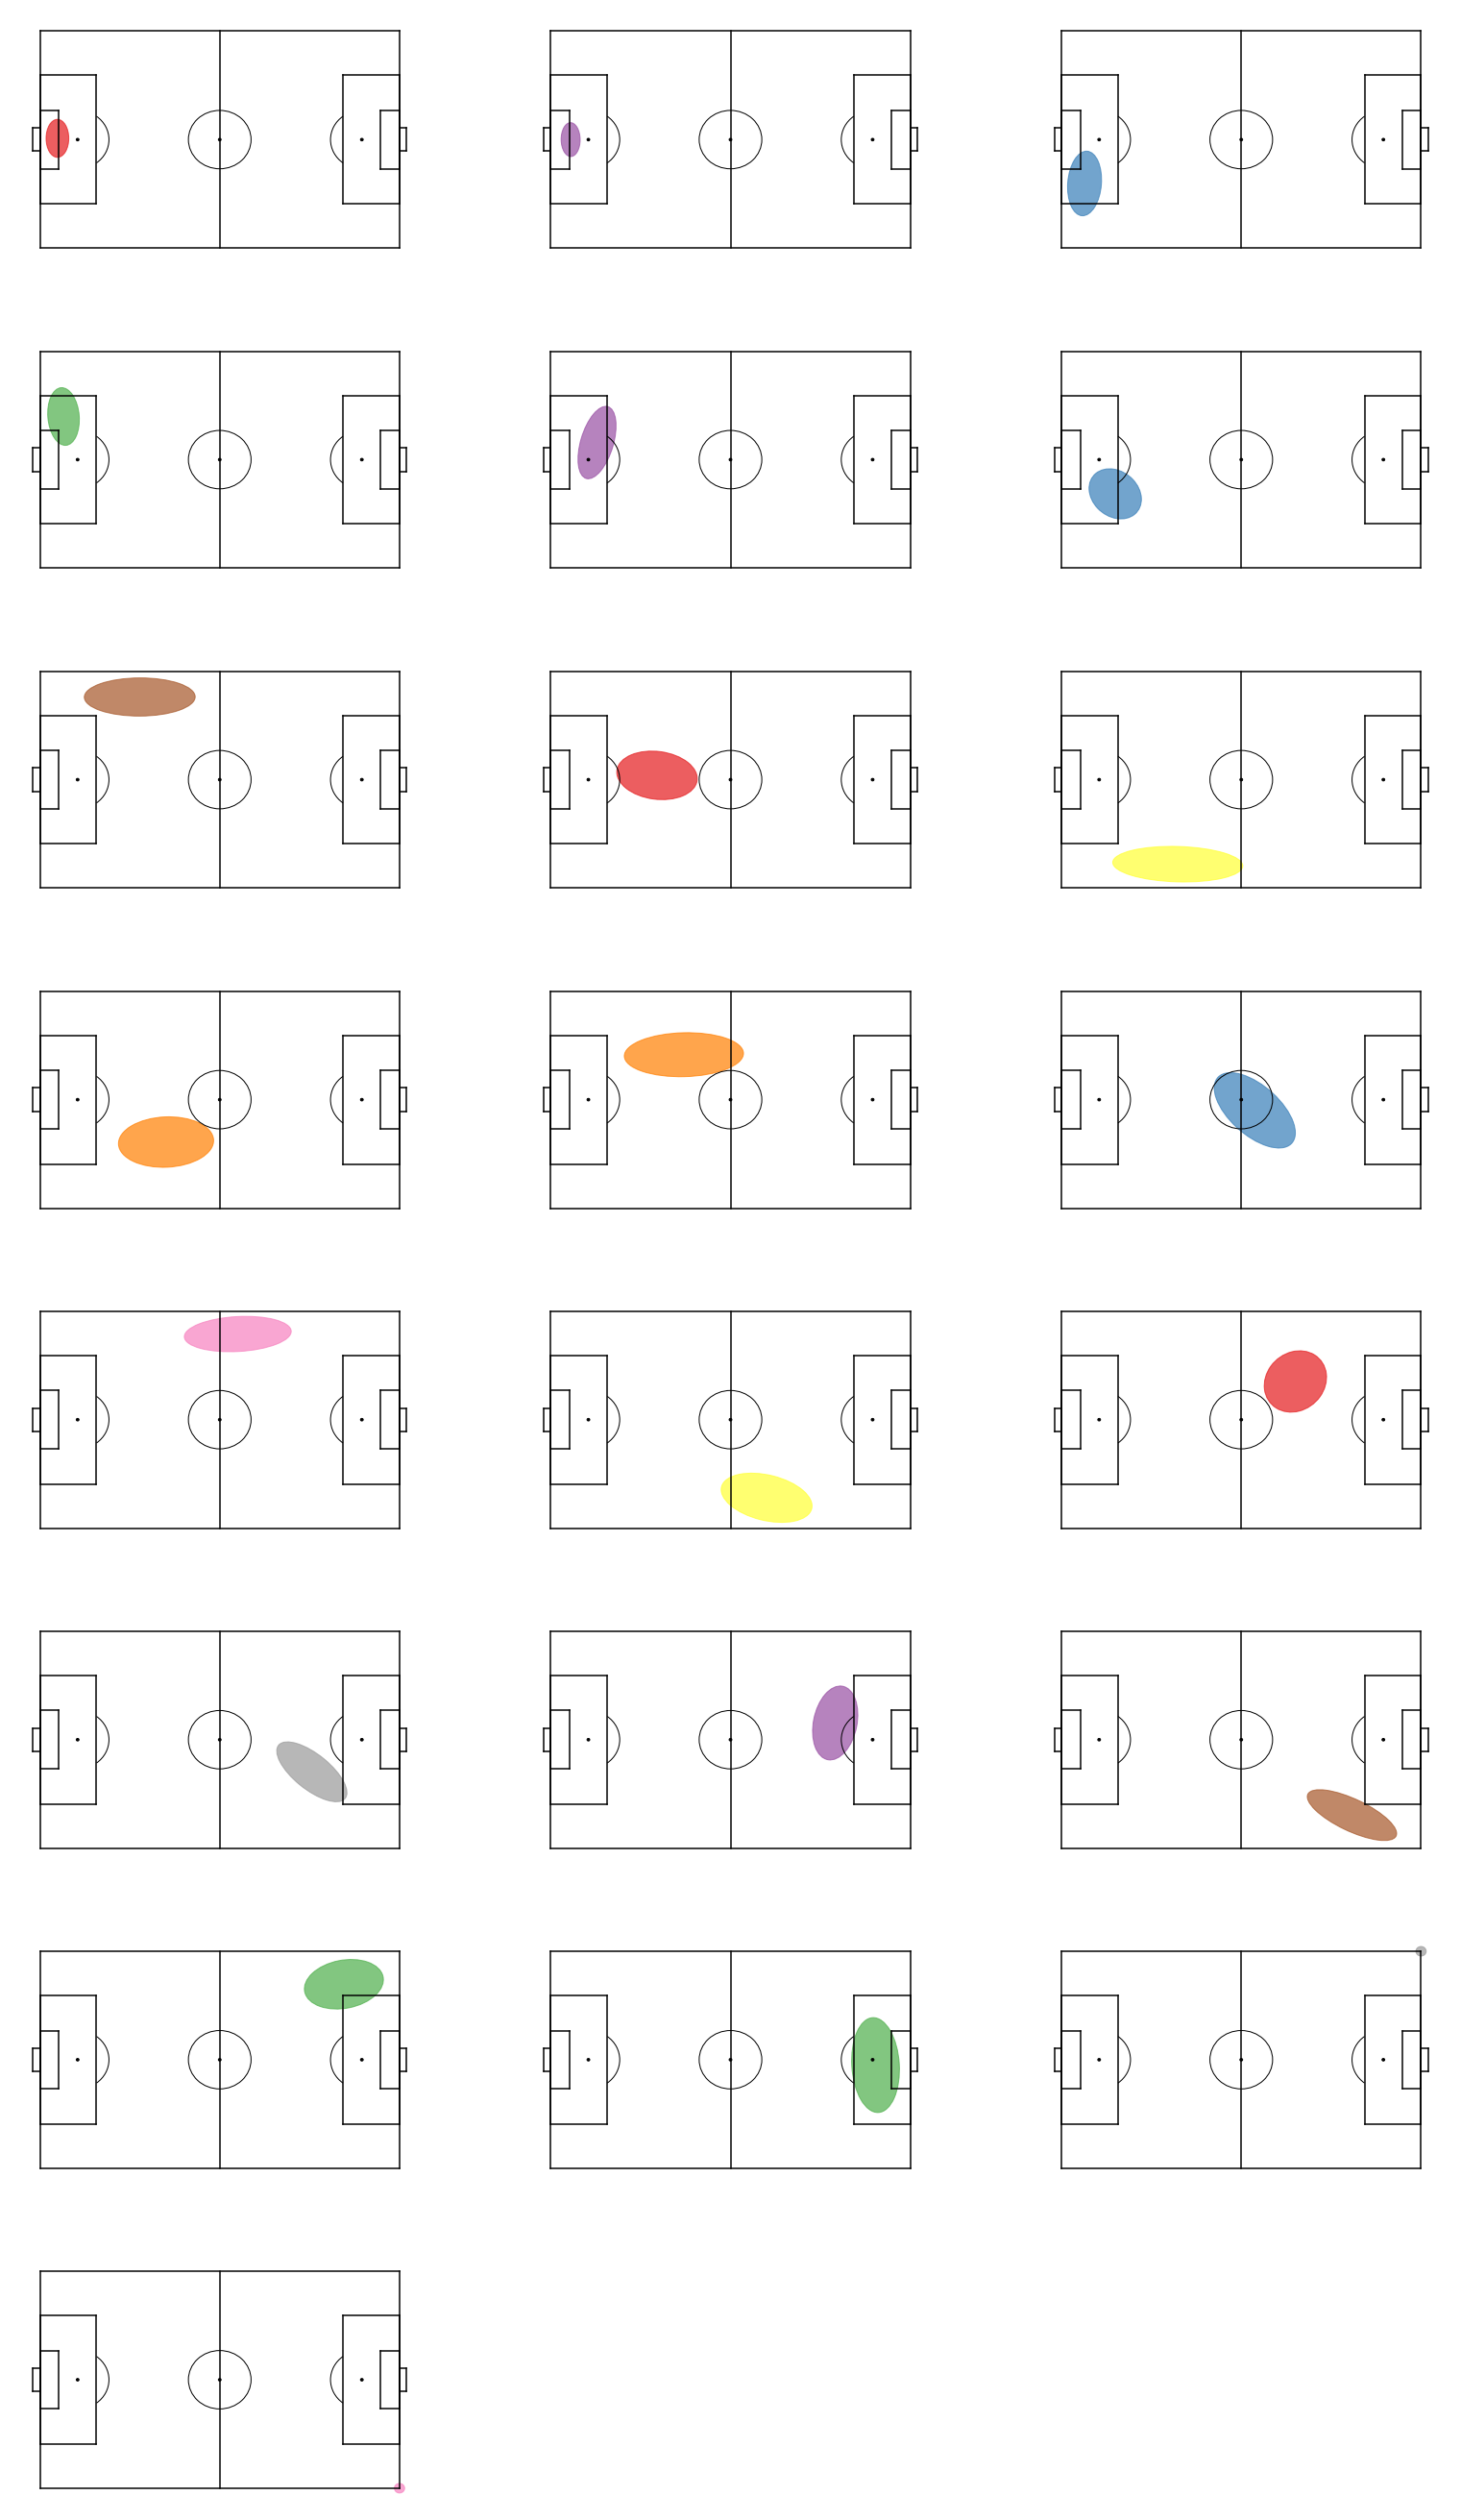

keeper_catch 2 3827


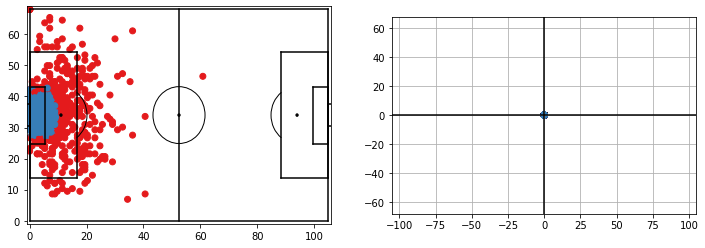

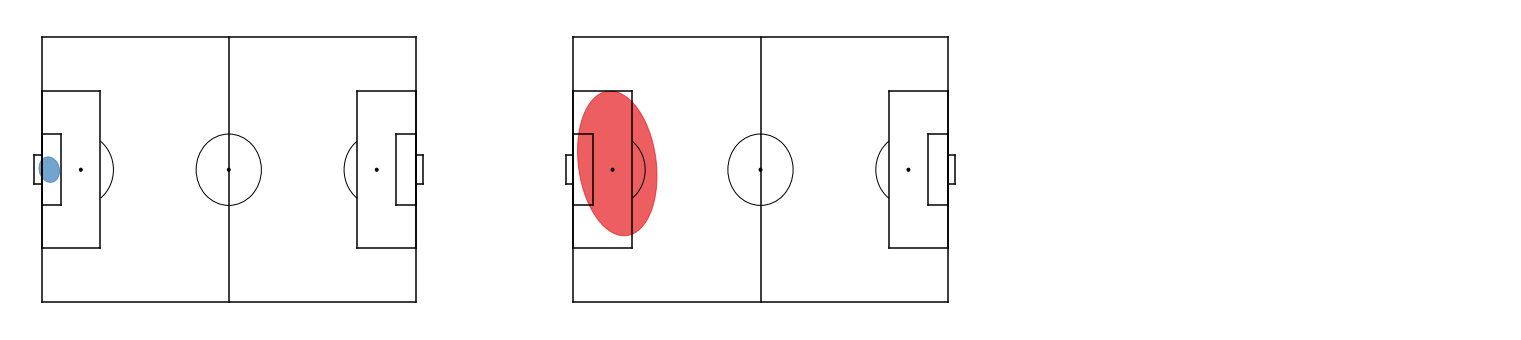

offside 1 1408


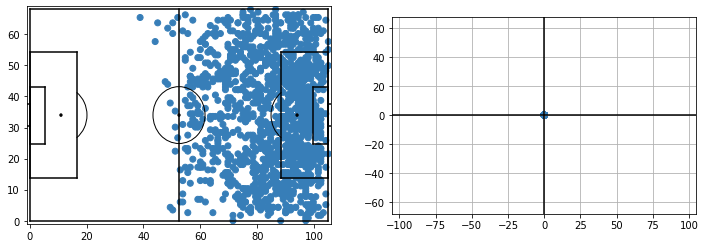

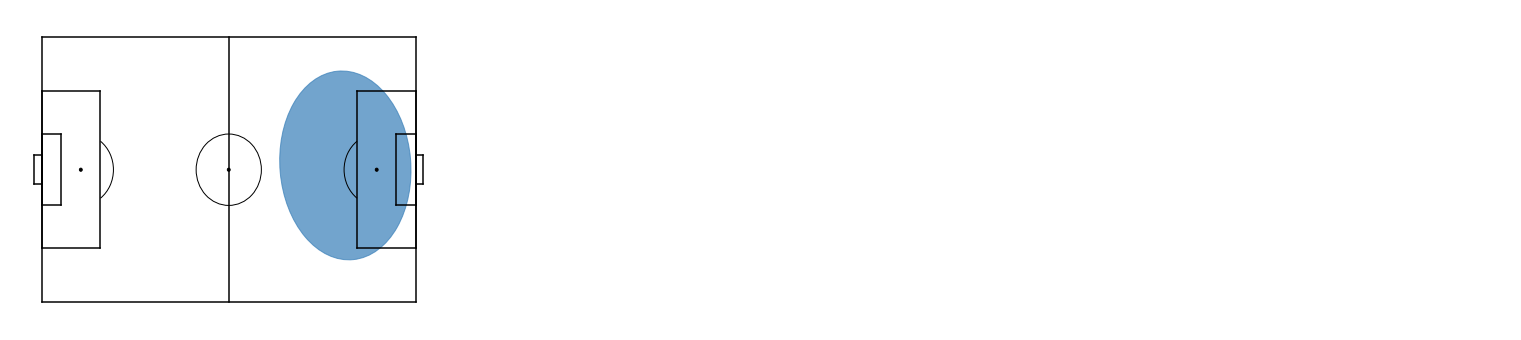

out 10 15472


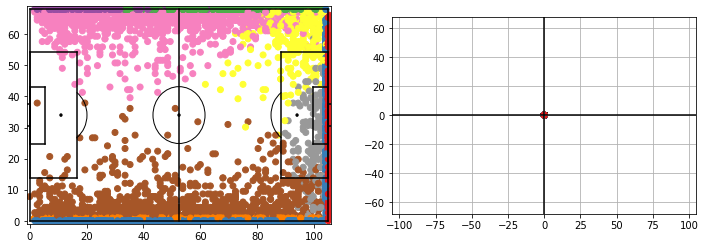

../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


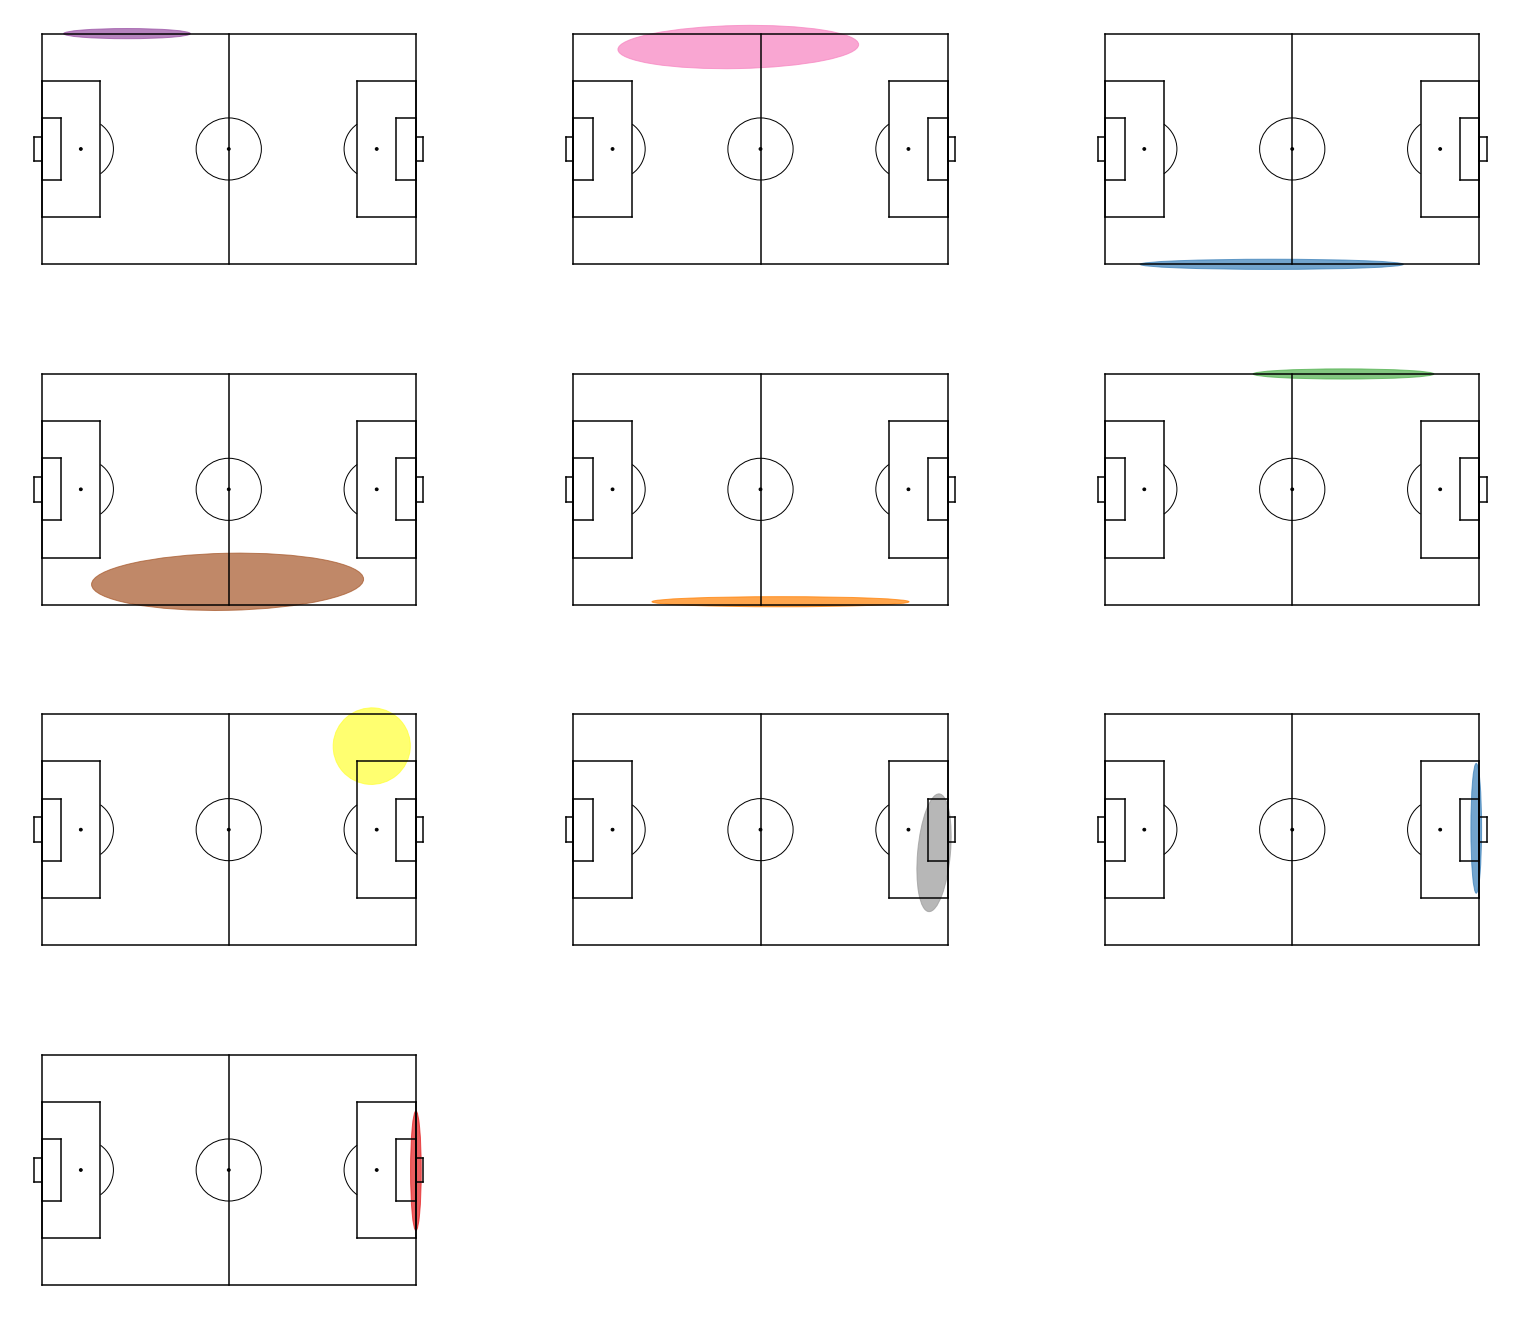

owngoal 1 32


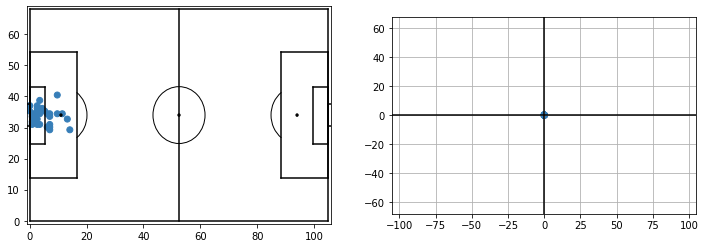

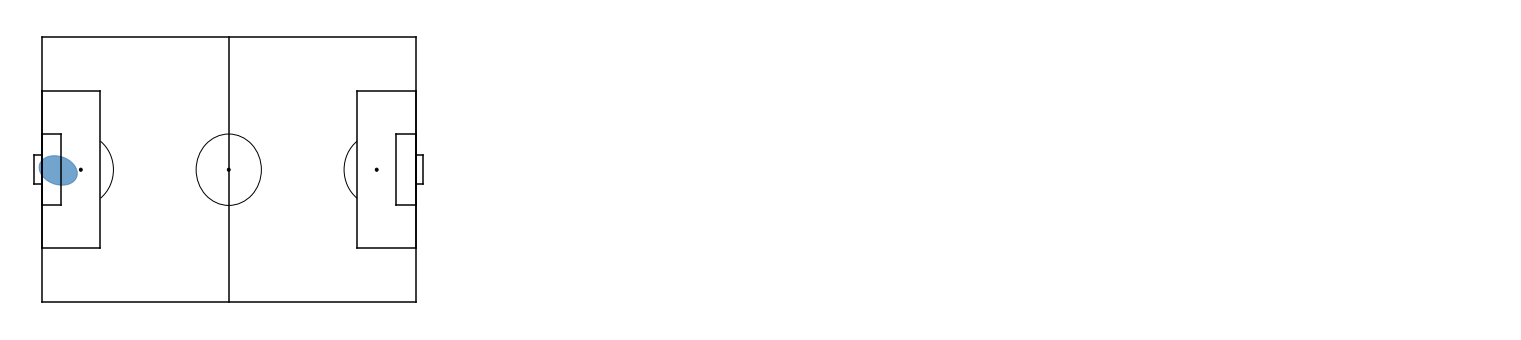

pass 24 337078


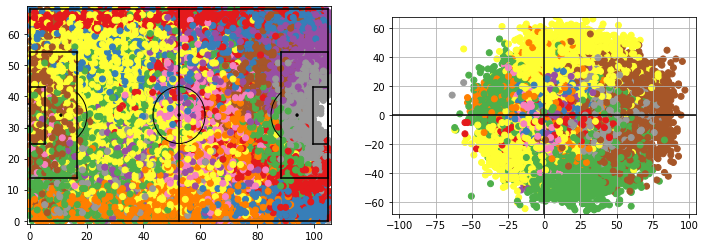

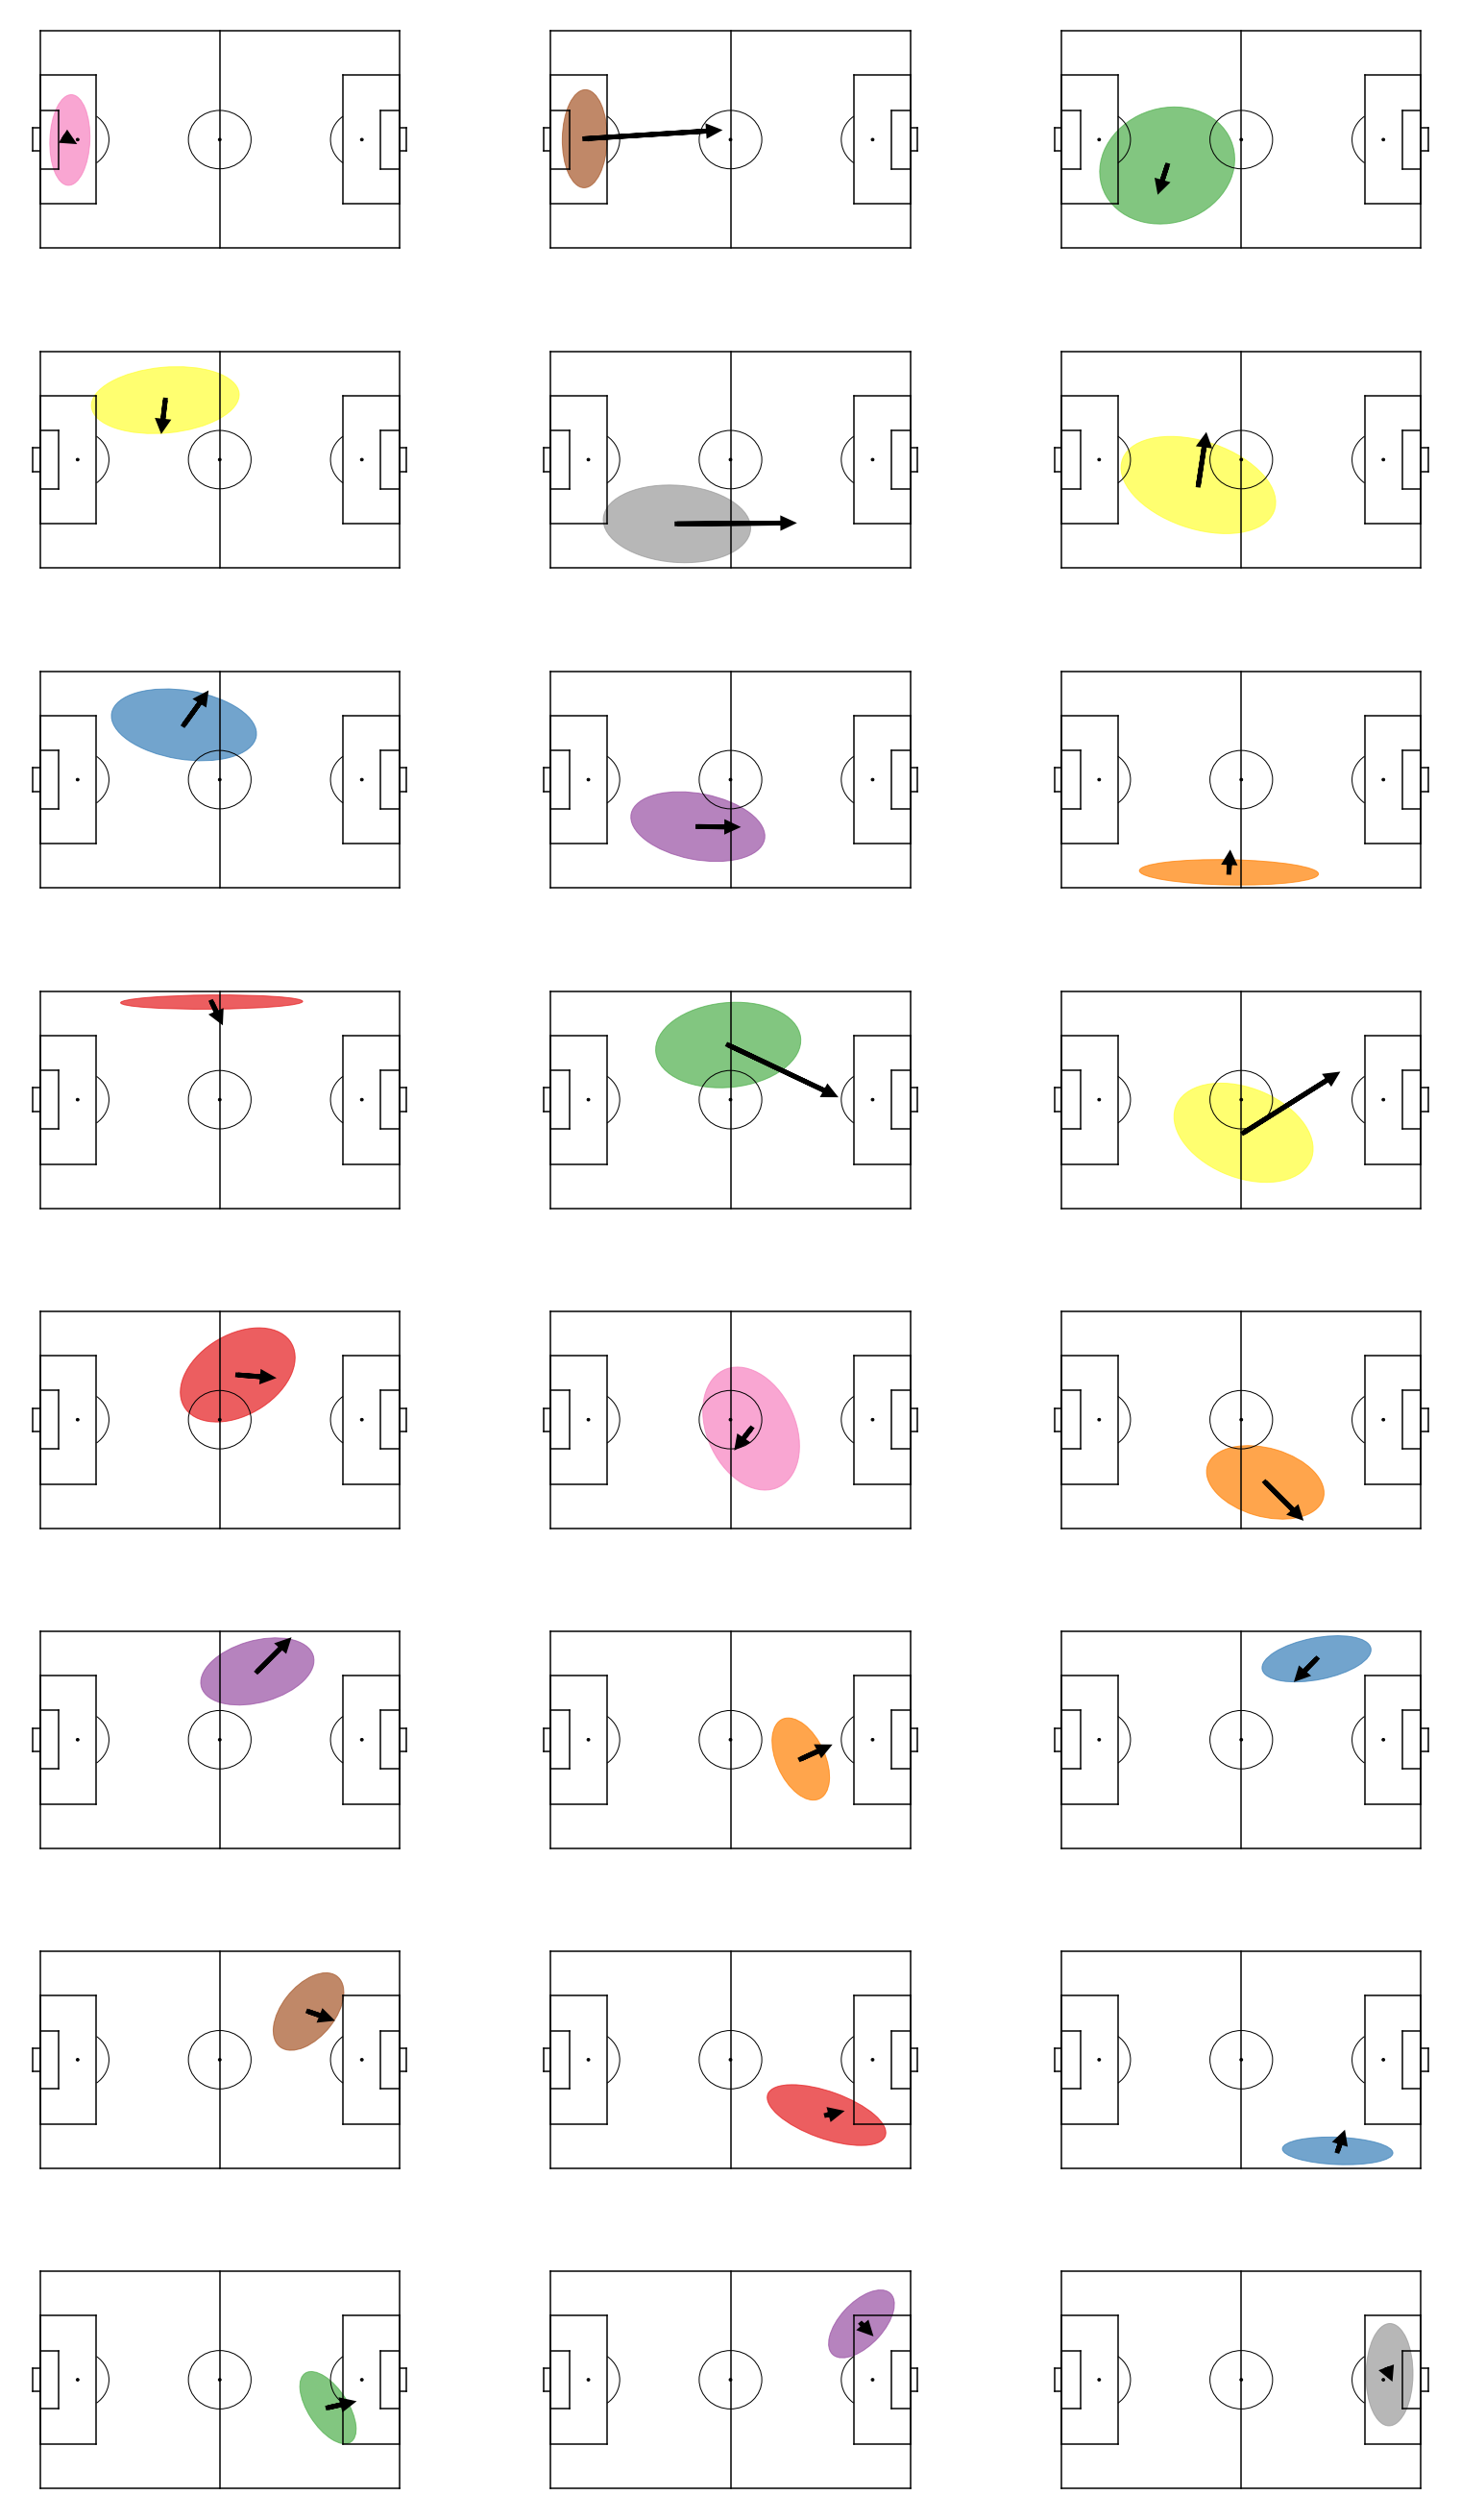

receival 21 307851


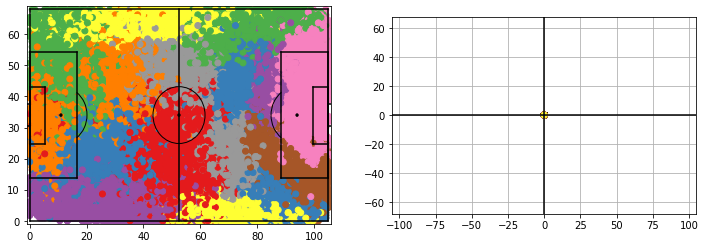

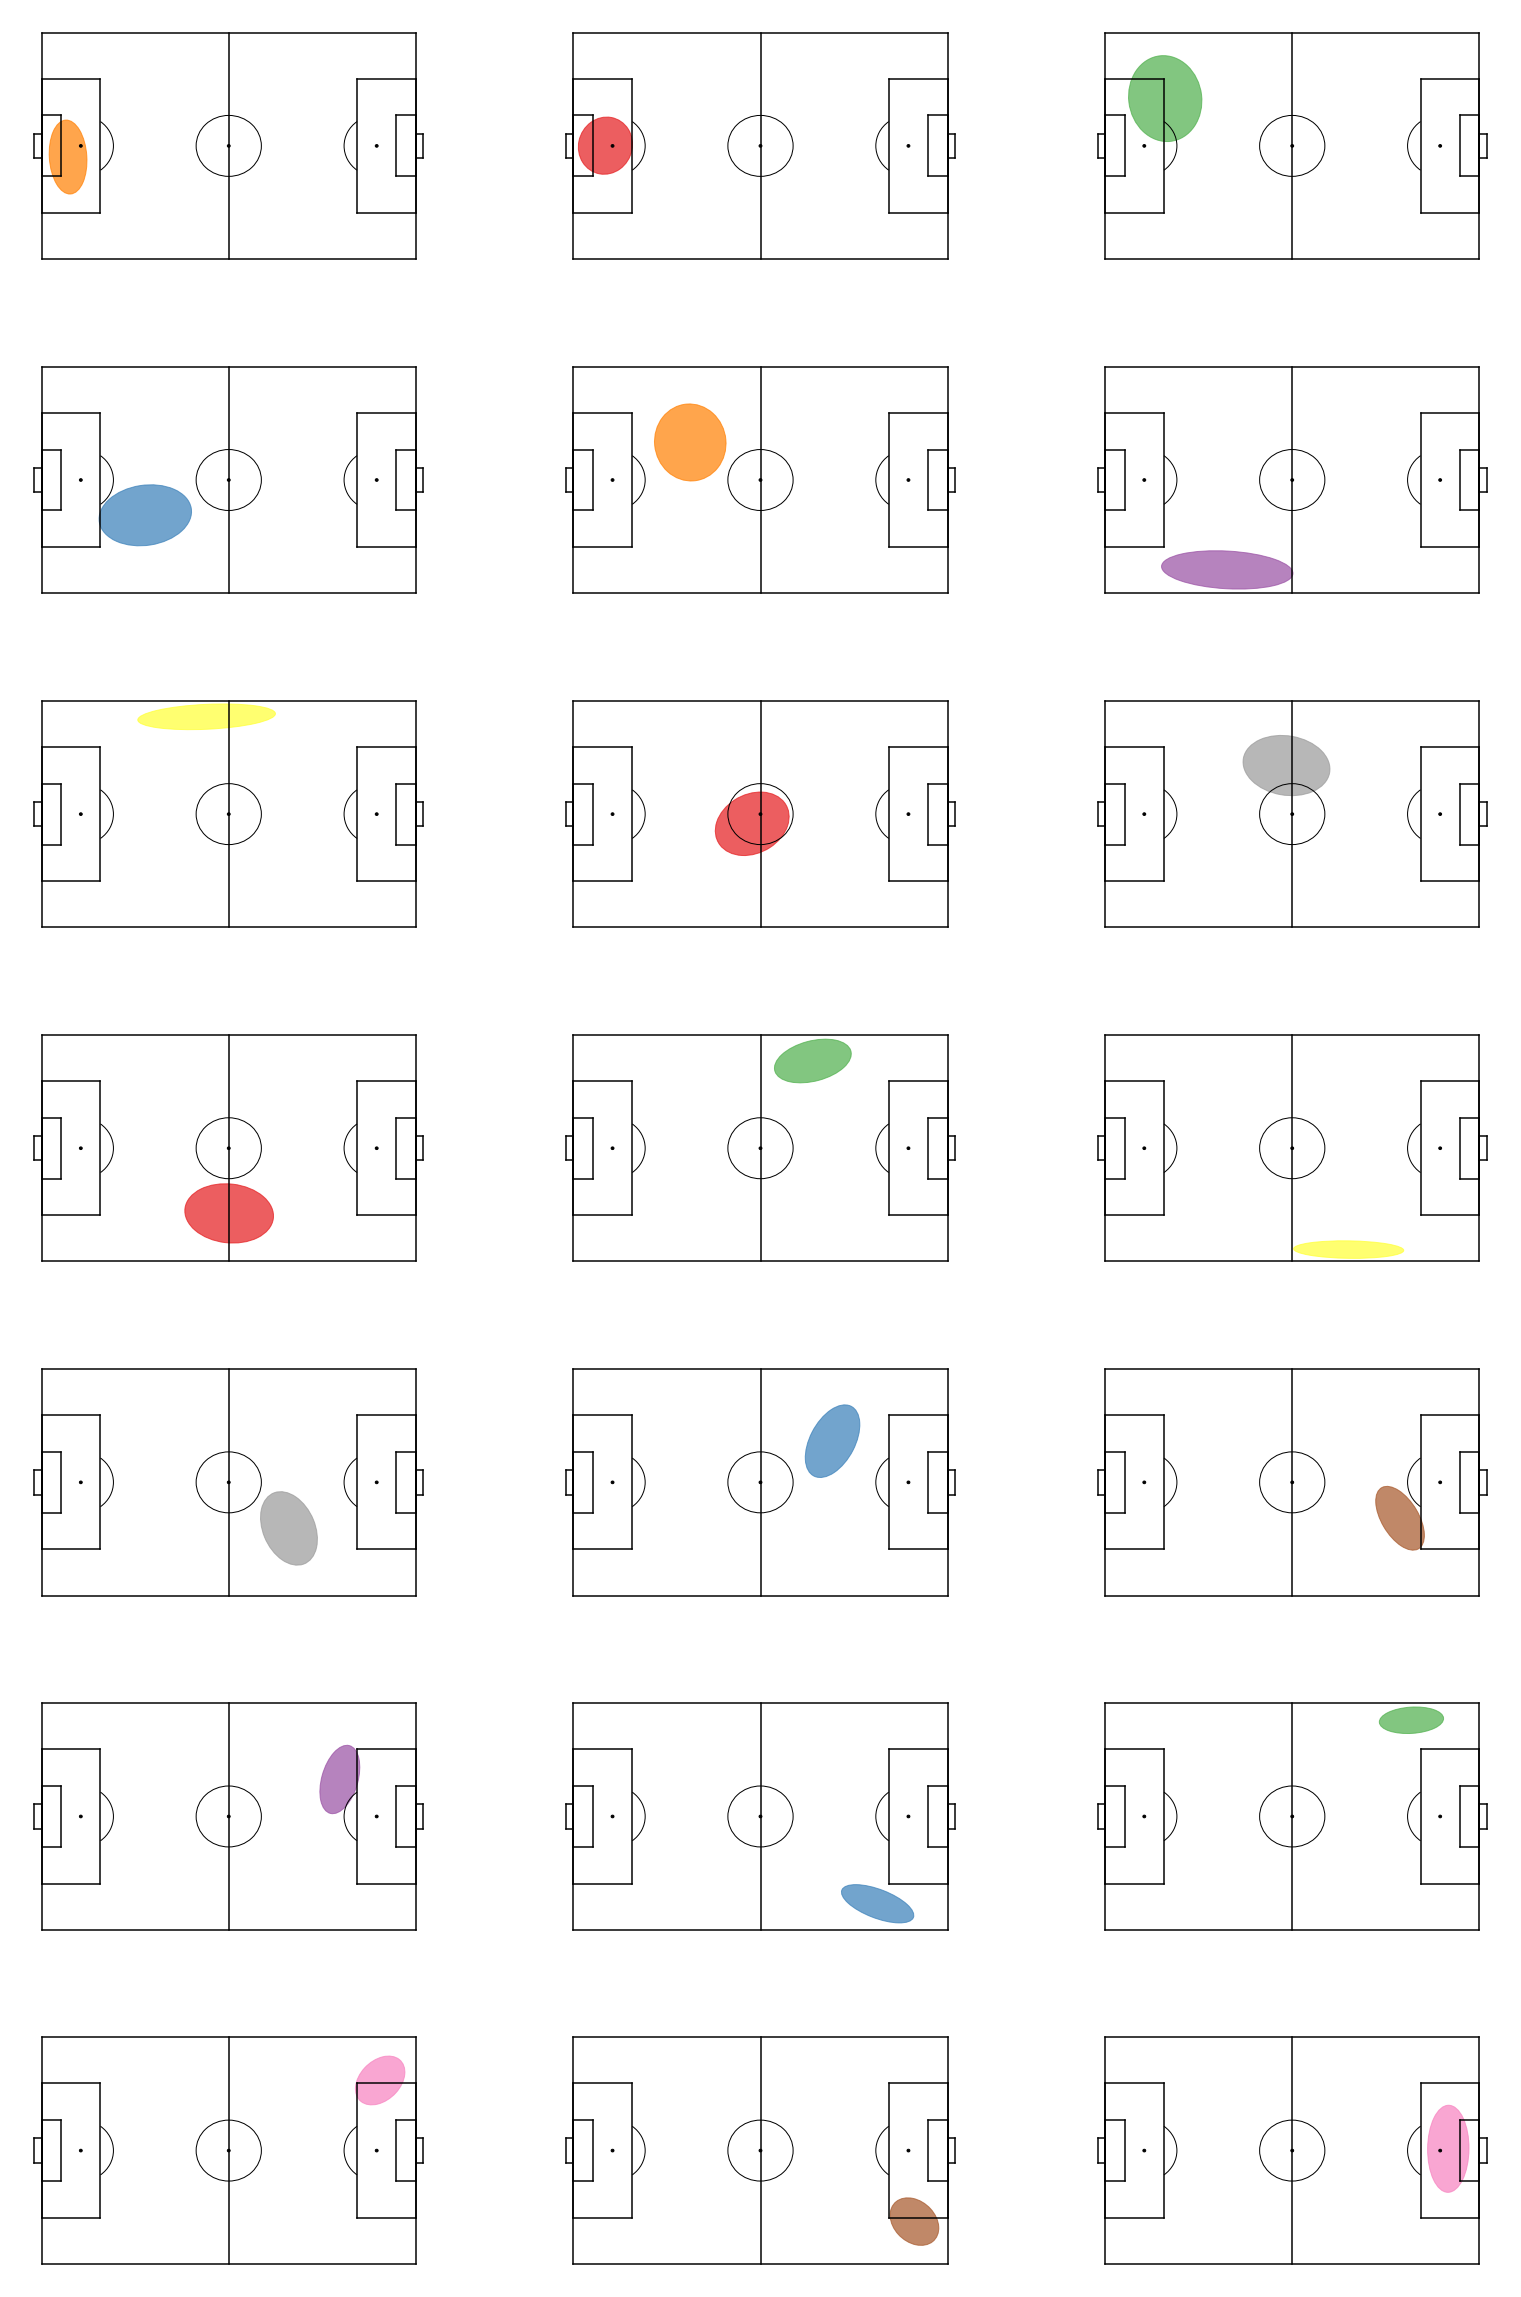

red_card 1 27


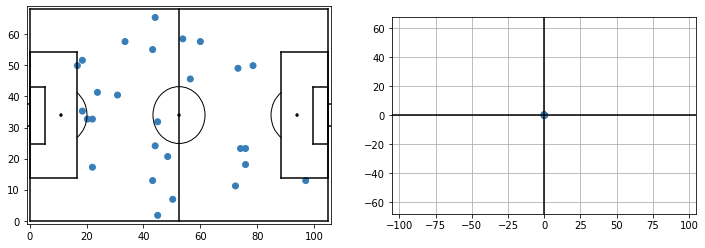

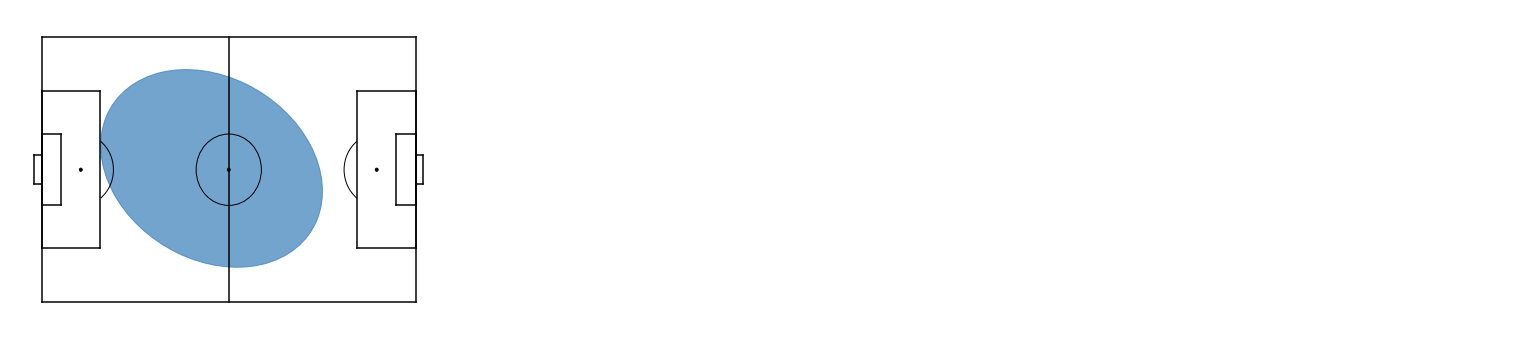

shot 7 9199


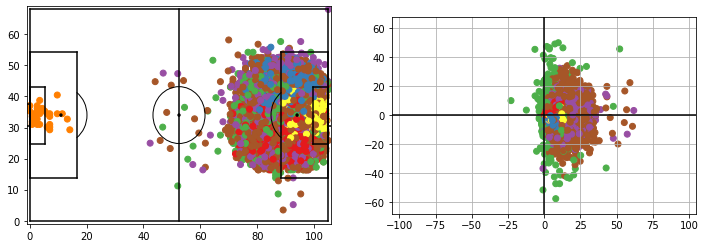

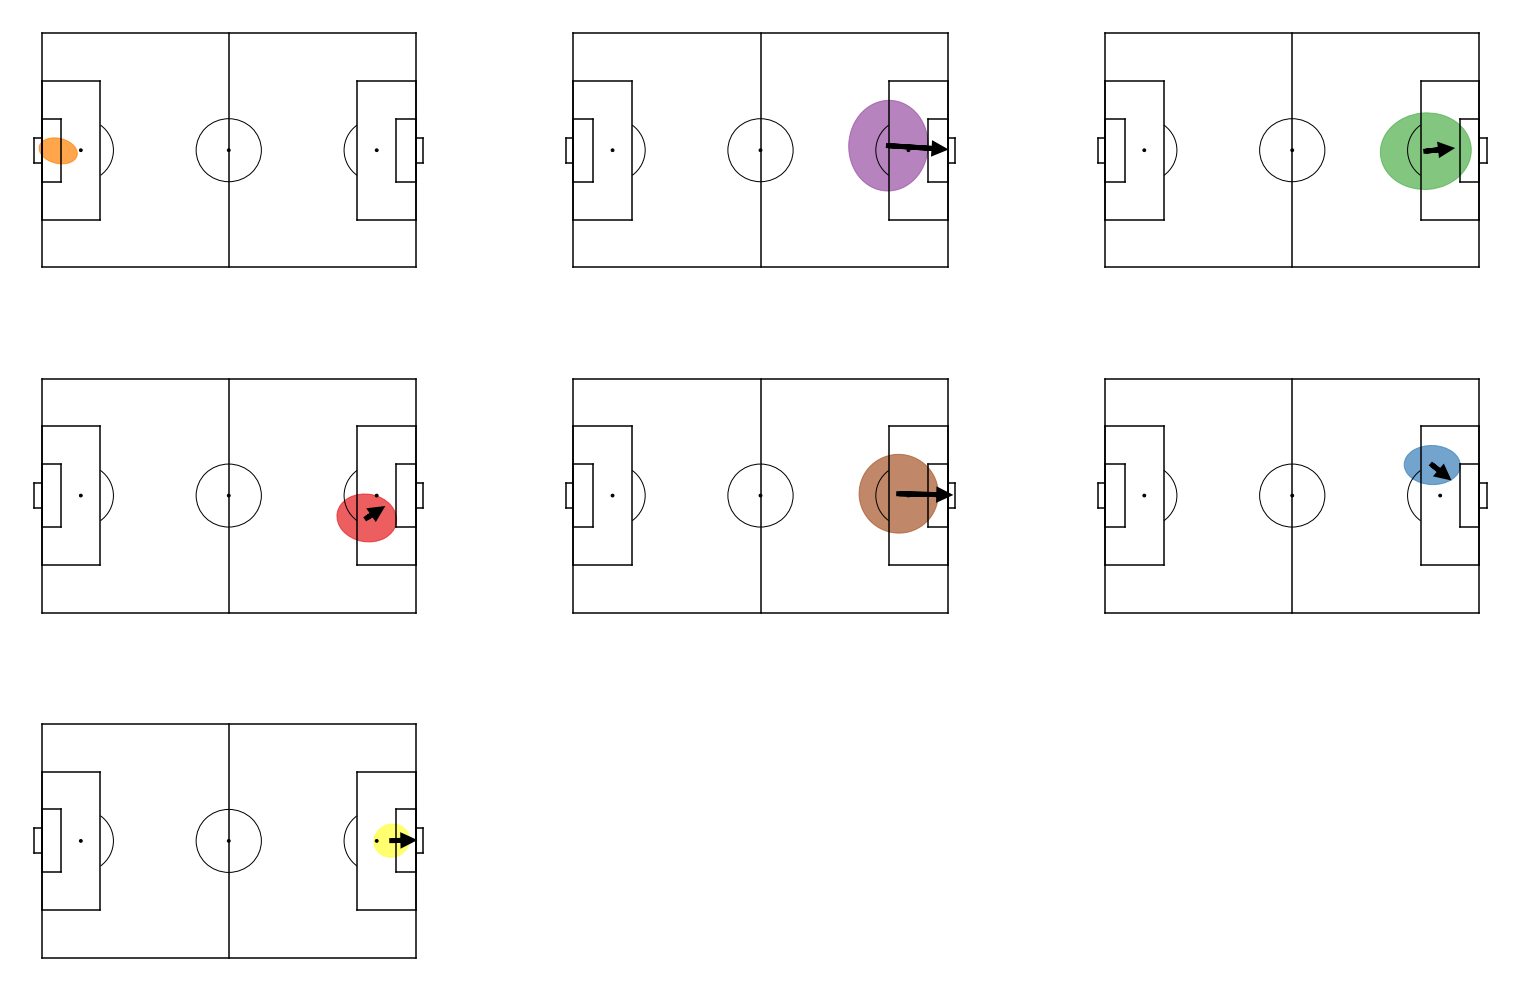

shot_penalty 1 103


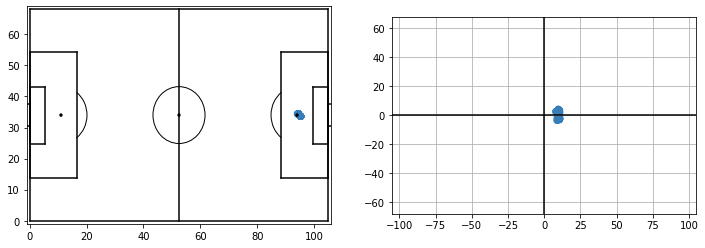

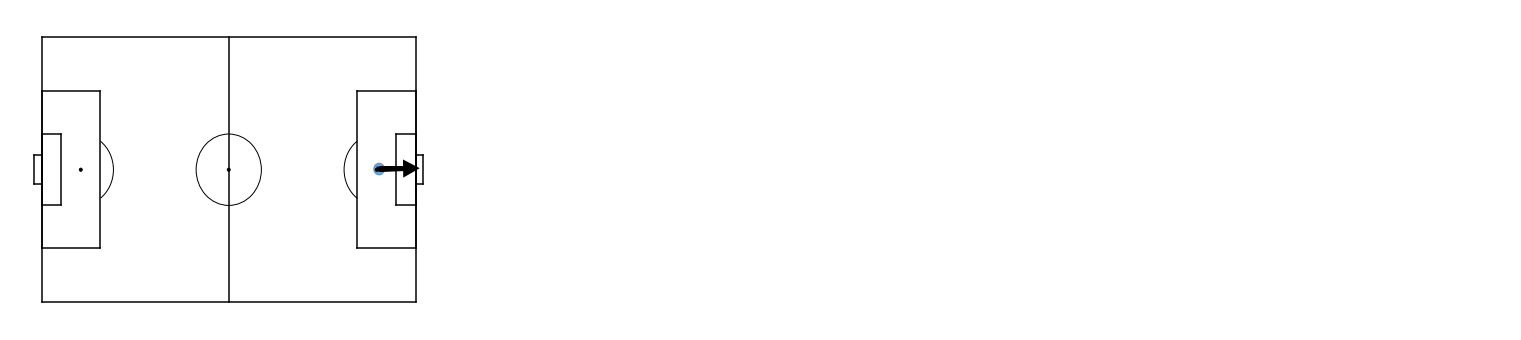

tackle 4 13034


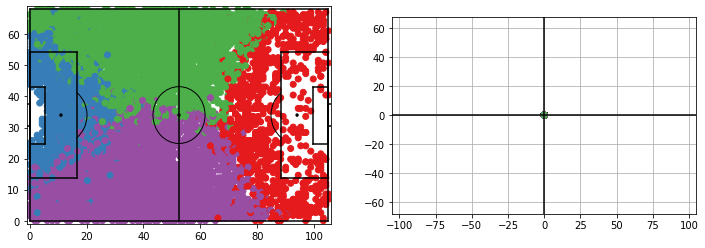

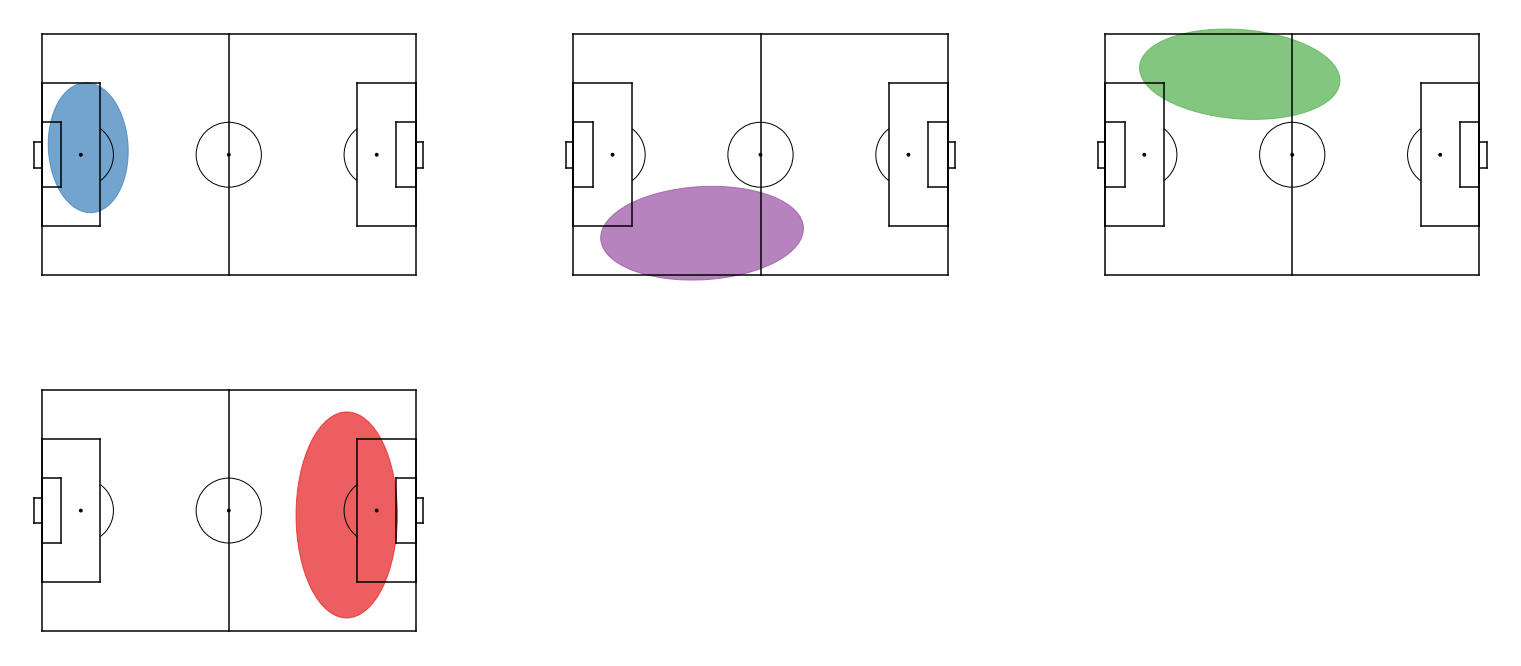

take_on 5 11675


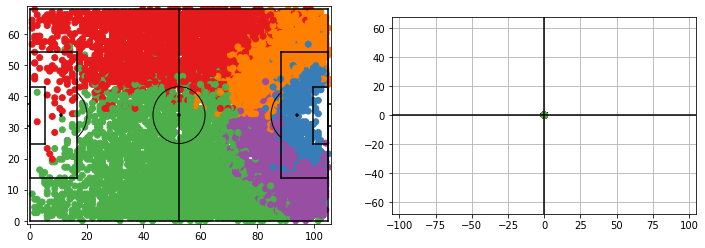

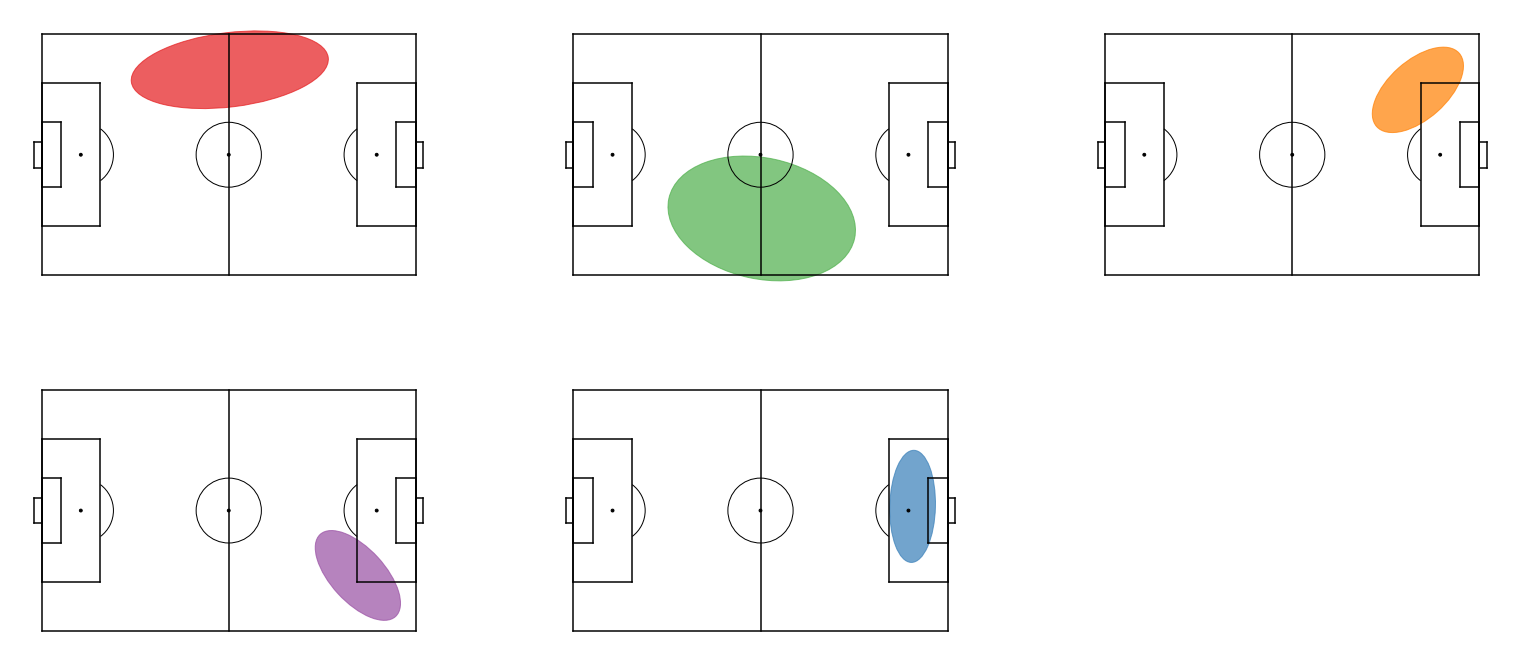

throw_in 3 16380


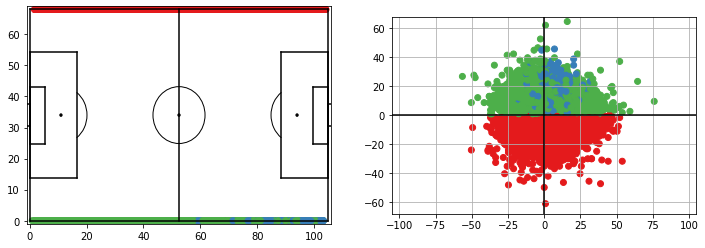

../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


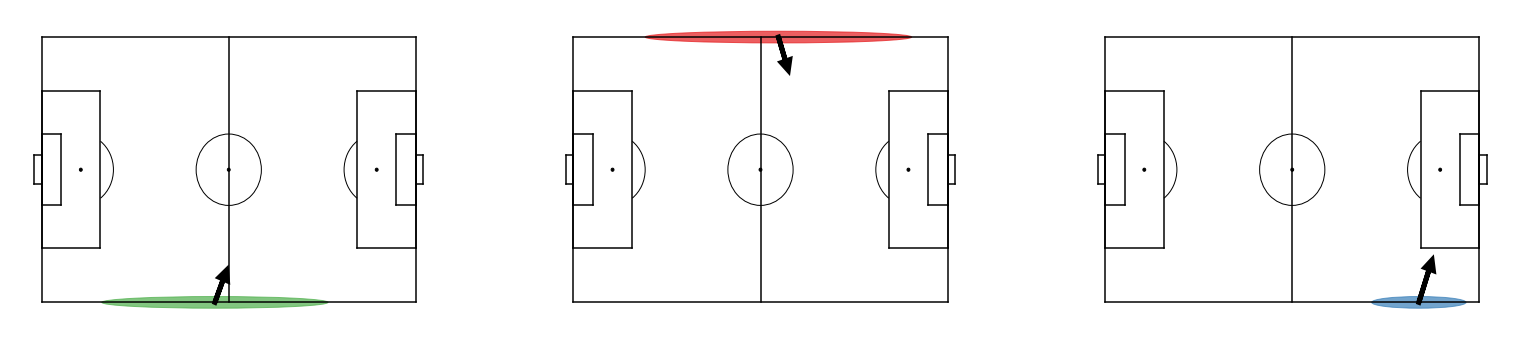

yellow_card 2 989


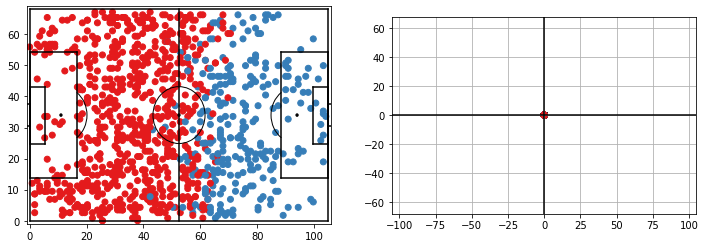

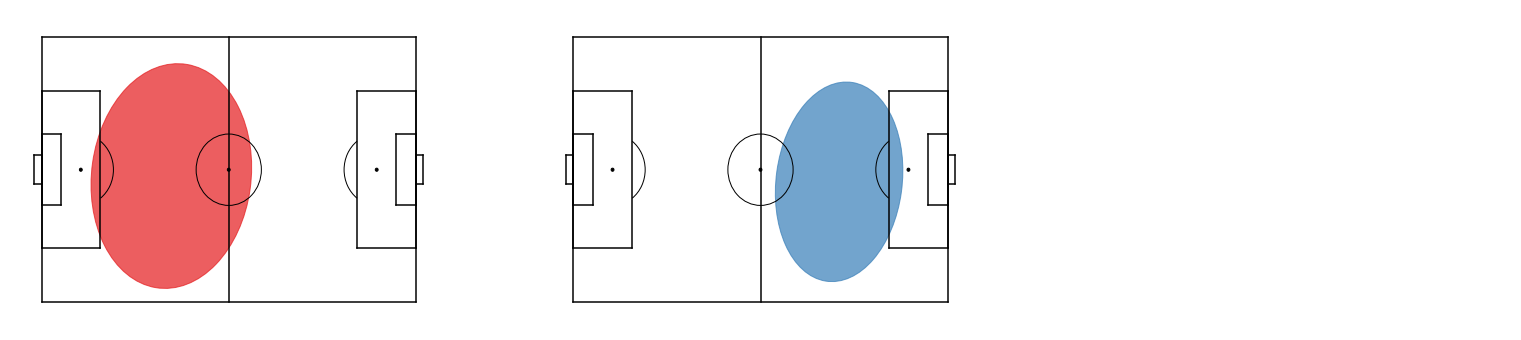

In [98]:
import pattern.vis as vis
for k, gmm in sorted(list(gmme.models.items())):
    df = a[a.type_name == k]
    print(k,gmm.n_components,len(df))
    #vis.plot_gmm(gmm)
    vis.plot_gmm_actions(gmm,df,gmme.cols,samplefn="uni")
    vis.plot_components_arrows(gmm,cols=3)

In [99]:
probas = gmme.predict_proba(a)

In [ ]:
for ty in gmme.models:
    for k in range(gmme.models[ty].n_components):
        col = ty + str(k+1)
        print(col)
        v = probas[col].values
        
        fig,axs = plt.subplots(1,2)
        fig.set_size_inches(3*6,6)
        axs[0].hist(v[v>0.01])
        mps.field(ax=axs[1],show=False)
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=axs[1])
        plt.show()

In [100]:
ucprobas = pat.uncouple_probabilities(probas,a.is_home.values)
ucprobas
ucprobas.values.sum()

1188669.9999999995

(1188669, 300)


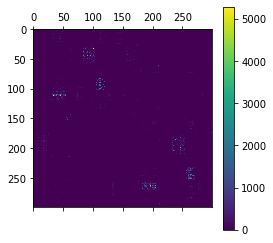

In [101]:
prev = ucprobas.values[:-1]
nex = ucprobas.values[1:]
print(prev.shape)
trans = np.dot(prev.T,nex)
plt.matshow(trans)
plt.colorbar()
plt.show()
trans /= trans.sum()
# for i in range(len(trans[0])):
#     trans[i,:] /= trans[i,:].sum()
trans.sum()
ori_trans = trans

In [113]:
forwardtrans = trans.copy()
for i in range(len(forwardtrans[0])):
     forwardtrans[i,:] /= forwardtrans[i,:].sum()
forwardtrans.sum()

backwardtrans = trans.T.copy()
for i in range(len(backwardtrans[0])):
     backwardtrans[i,:] /= backwardtrans[i,:].sum()
backwardtrans.sum()

300.0

In [176]:
def get_name(i):
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    return "_".join([ty,str(k),str(is_opp)])

0
Counter({('interception', False): 7, ('interception', True): 6, ('receival', False): 5, ('out', False): 4, ('receival', True): 2, ('keeper_catch', True): 2, ('goal', False): 1, ('out', True): 1, ('tackle', True): 1})


../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


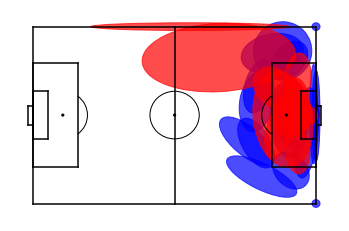

1
Counter({('dribble', False): 14, ('interception', False): 1, ('owngoal', False): 1, ('goal', True): 1})


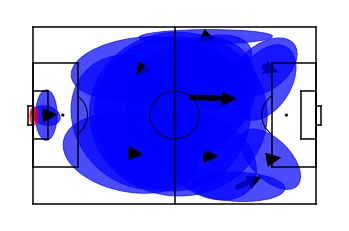

2
Counter({('pass', False): 10, ('shot', False): 6, ('cross', False): 4, ('corner', False): 4, ('take_on', False): 3, ('throw_in', False): 1, ('bad_touch', False): 1, ('dribble', False): 1, ('tackle', True): 1})


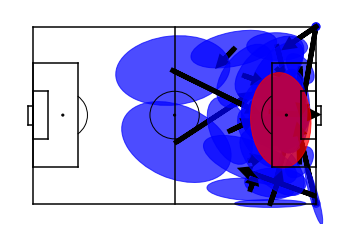

3
Counter({('pass', True): 9, ('shot', True): 6, ('cross', True): 4, ('dribble', True): 4, ('corner', True): 4, ('take_on', True): 3, ('tackle', False): 1, ('throw_in', True): 1, ('bad_touch', True): 1})


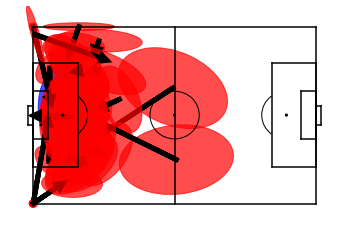

4
Counter({('foul', False): 4, ('yellow_card', False): 2, ('freekick', True): 2, ('red_card', False): 1, ('offside', False): 1, ('shot_penalty', True): 1})


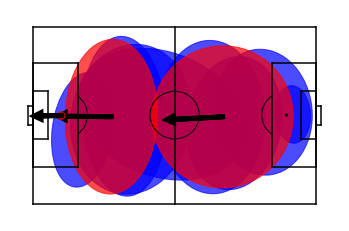

5
Counter({('pass', False): 14, ('clearance', False): 11, ('goalkick', False): 2, ('throw_in', False): 2, ('shot', False): 1})


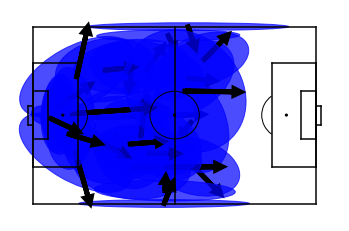

6
Counter({('foul', True): 4, ('freekick', False): 2, ('yellow_card', True): 2, ('shot_penalty', False): 1, ('red_card', True): 1, ('offside', True): 1})


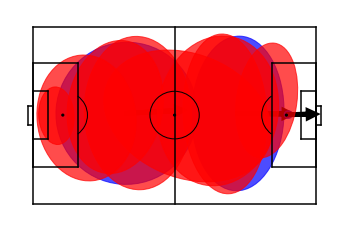

7
Counter({('pass', True): 15, ('clearance', True): 11, ('goalkick', True): 2, ('throw_in', True): 2, ('take_on', True): 2, ('bad_touch', True): 1, ('shot', True): 1, ('dribble', True): 1})


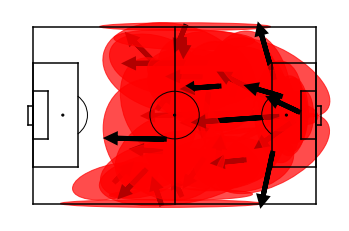

8
Counter({('receival', False): 16, ('interception', True): 16, ('dribble', True): 10, ('out', False): 6, ('tackle', False): 3, ('bad_touch', False): 2, ('take_on', False): 2, ('owngoal', True): 1})


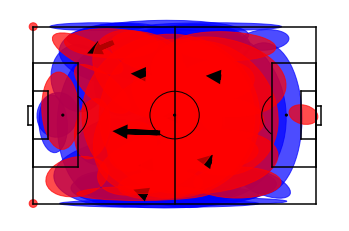

9
Counter({('receival', True): 19, ('interception', False): 14, ('out', True): 9, ('keeper_catch', False): 2, ('tackle', True): 2, ('bad_touch', True): 1})


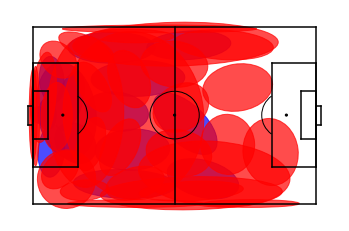

In [213]:
from sklearn.cluster import SpectralClustering

nc = 10

clustering = SpectralClustering(affinity="precomputed",n_clusters=nc).fit((sim + sim.T)/2)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clustering.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

0
Counter({('interception', False): 6, ('receival', True): 5, ('keeper_catch', False): 1, ('interception', True): 1, ('out', True): 1})


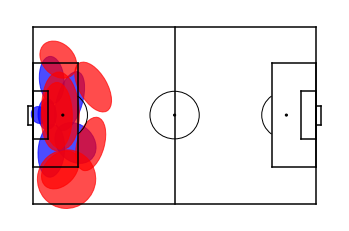

1
Counter({('pass', False): 12, ('take_on', False): 3, ('clearance', False): 3, ('throw_in', False): 2, ('bad_touch', False): 2, ('corner', False): 2, ('foul', True): 2, ('tackle', True): 2, ('cross', False): 1, ('goalkick', False): 1, ('shot', True): 1})


../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


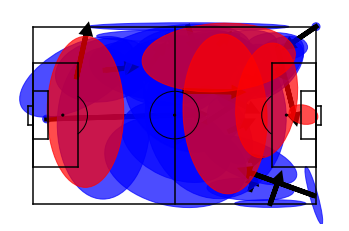

2
Counter({('out', True): 3})


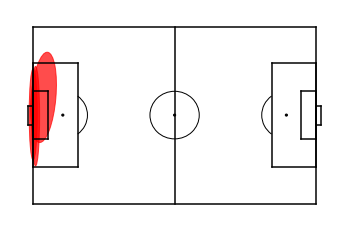

3
Counter({('out', False): 3})


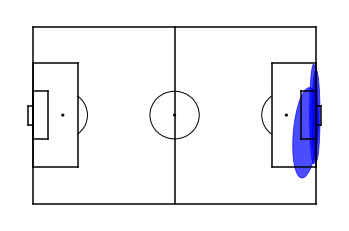

4
Counter({('pass', True): 16, ('throw_in', True): 1, ('clearance', True): 1})


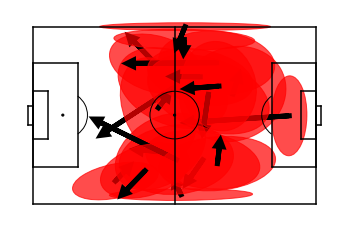

5
Counter({('receival', False): 12, ('out', False): 1})


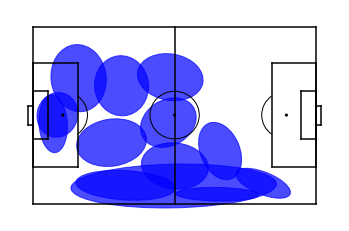

6
Counter({('receival', True): 5, ('interception', False): 2, ('out', True): 1})


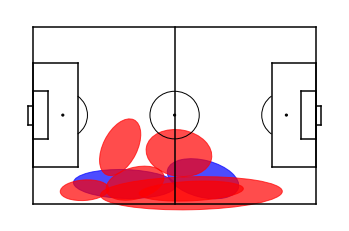

7
Counter({('yellow_card', False): 2, ('freekick', True): 2, ('red_card', False): 1})


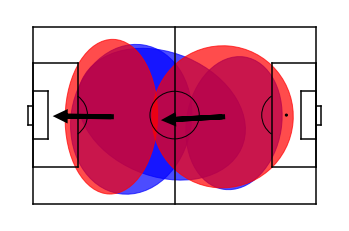

8
Counter({('pass', False): 10, ('clearance', False): 8, ('goalkick', False): 1, ('throw_in', False): 1})


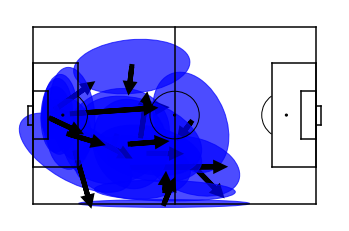

9
Counter({('receival', False): 6, ('out', False): 2})


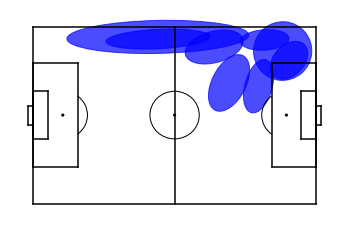

10
Counter({('dribble', False): 6})


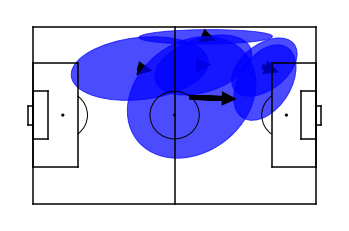

11
Counter({('out', True): 2, ('interception', False): 1})


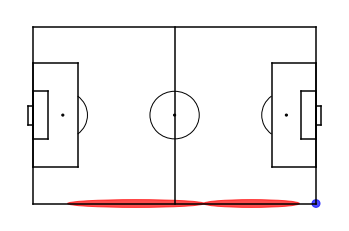

12
Counter({('freekick', False): 2, ('yellow_card', True): 2, ('red_card', True): 1})


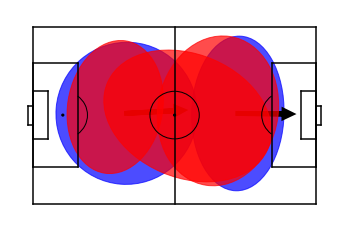

13
Counter({('receival', True): 11, ('out', True): 1})


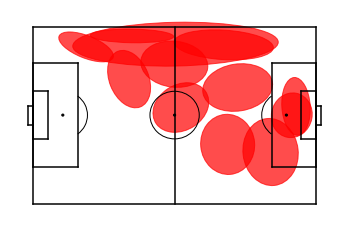

14
Counter({('interception', True): 13, ('interception', False): 11, ('keeper_catch', False): 1, ('tackle', True): 1, ('keeper_catch', True): 1})


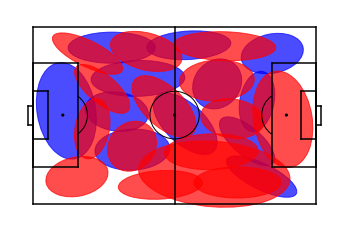

15
Counter({('dribble', True): 14, ('goal', False): 1, ('owngoal', True): 1})


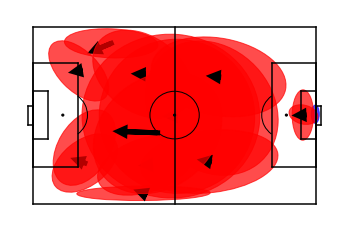

16
Counter({('clearance', True): 8, ('pass', True): 1})


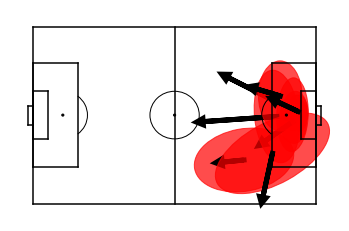

17
Counter({('shot', False): 6, ('cross', False): 3, ('pass', False): 2, ('dribble', False): 2, ('corner', False): 2, ('take_on', False): 2, ('bad_touch', False): 1, ('shot_penalty', False): 1, ('tackle', True): 1})


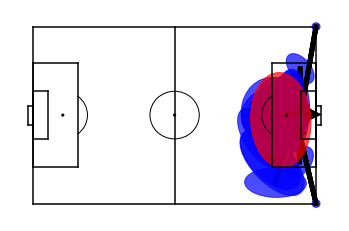

18
Counter({('dribble', False): 7, ('goal', True): 1})


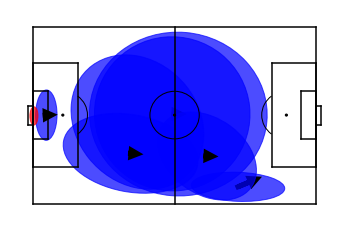

19
Counter({('shot', False): 1})


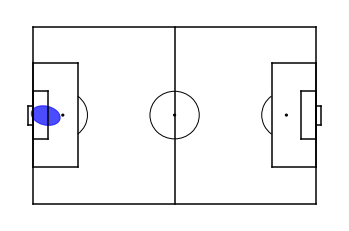

20
Counter({('shot', True): 6, ('cross', True): 4, ('corner', True): 4, ('pass', True): 3, ('bad_touch', True): 1, ('dribble', True): 1, ('shot_penalty', True): 1, ('take_on', True): 1})


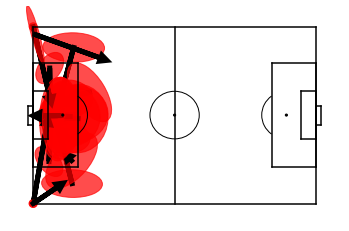

21
Counter({('foul', True): 2, ('offside', True): 1})


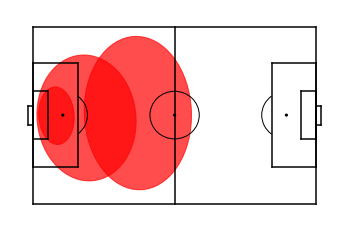

22
Counter({('foul', False): 4, ('offside', False): 1})


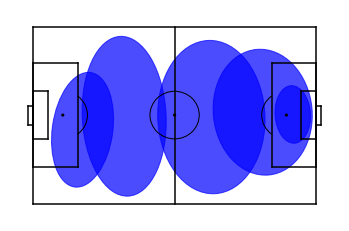

23
Counter({('out', False): 2, ('interception', True): 1})


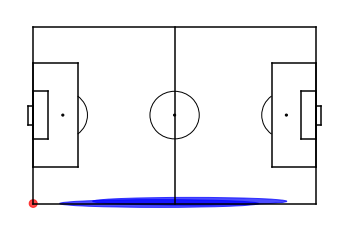

24
Counter({('goalkick', True): 2})


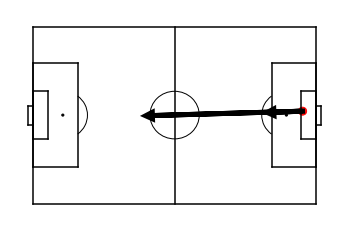

25
Counter({('owngoal', False): 1})


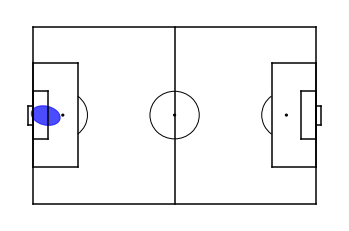

26
Counter({('interception', True): 6, ('receival', False): 3, ('interception', False): 1, ('keeper_catch', True): 1})


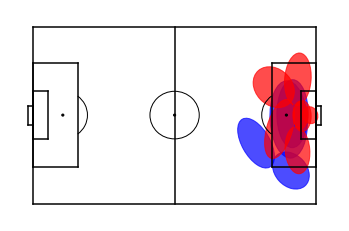

27
Counter({('out', True): 2, ('interception', False): 1})


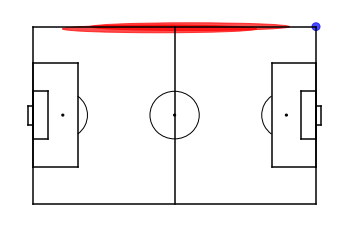

28
Counter({('tackle', False): 4, ('pass', True): 4, ('take_on', True): 4, ('throw_in', True): 2, ('bad_touch', True): 2, ('clearance', True): 2})


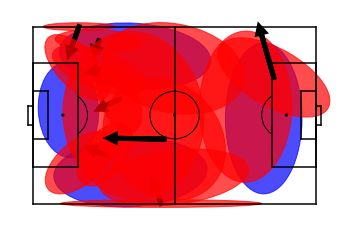

29
Counter({('out', False): 2, ('interception', True): 1})


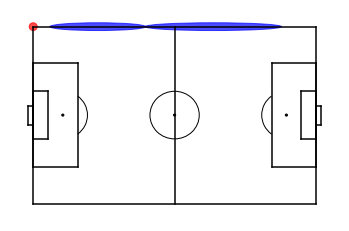

In [210]:
sim = (np.dot(forwardtrans,backwardtrans) + np.dot(backwardtrans,forwardtrans))/2

from sklearn.cluster import KMeans

nc = 30

clus = KMeans(nc).fit(sim)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clus.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

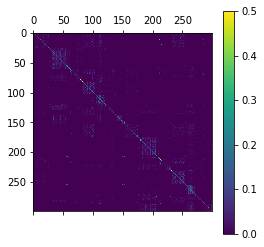

0
Counter({('dribble', True): 5})


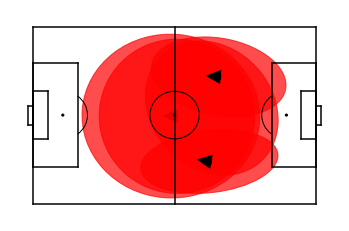

1


../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


Counter({('interception', True): 20, ('interception', False): 19, ('pass', False): 19, ('pass', True): 19, ('receival', False): 11, ('receival', True): 11, ('dribble', False): 10, ('clearance', False): 9, ('dribble', True): 9, ('clearance', True): 9, ('out', False): 6, ('out', True): 6, ('shot', False): 5, ('take_on', False): 5, ('shot', True): 5, ('take_on', True): 5, ('cross', False): 4, ('corner', False): 4, ('tackle', False): 4, ('cross', True): 4, ('corner', True): 4, ('tackle', True): 4, ('bad_touch', False): 3, ('bad_touch', True): 3, ('foul', False): 2, ('yellow_card', False): 2, ('keeper_catch', False): 2, ('foul', True): 2, ('yellow_card', True): 2, ('keeper_catch', True): 2, ('goalkick', False): 1, ('red_card', False): 1, ('throw_in', False): 1, ('shot_penalty', False): 1, ('goal', False): 1, ('offside', False): 1, ('goalkick', True): 1, ('red_card', True): 1, ('throw_in', True): 1, ('shot_penalty', True): 1, ('goal', True): 1, ('offside', True): 1})


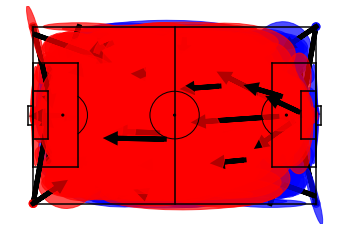

2
Counter({('receival', True): 7})


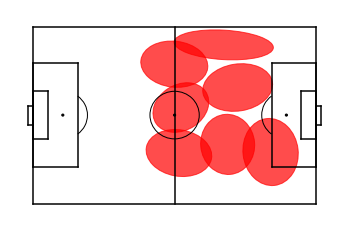

3
Counter({('dribble', False): 4})


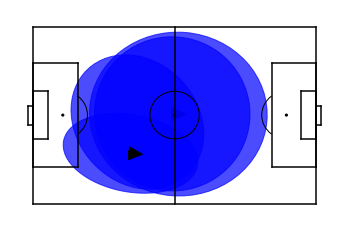

4
Counter({('receival', True): 2})


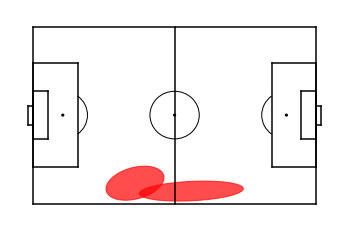

5
Counter({('pass', True): 2})


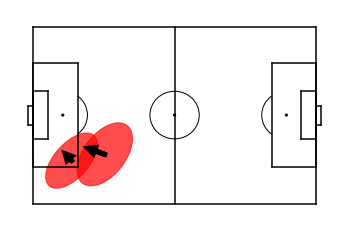

6
Counter({('pass', True): 2})


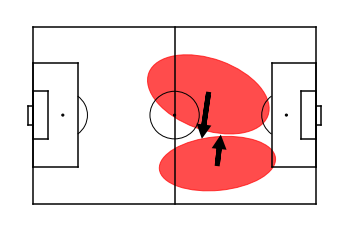

7
Counter({('receival', False): 7})


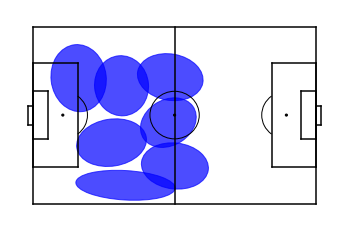

8
Counter({('out', True): 2, ('interception', False): 1})


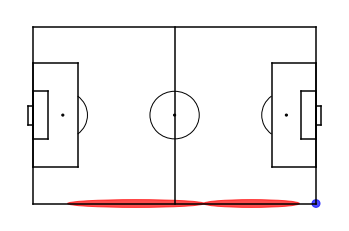

9
Counter({('receival', False): 2})


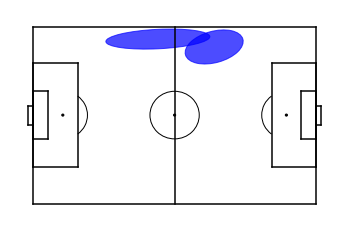

10
Counter({('pass', False): 2})


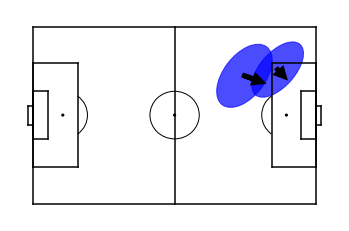

11
Counter({('dribble', True): 1})


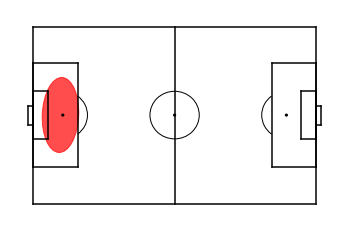

12
Counter({('out', True): 1})


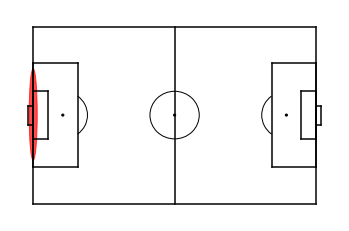

13
Counter({('receival', False): 1})


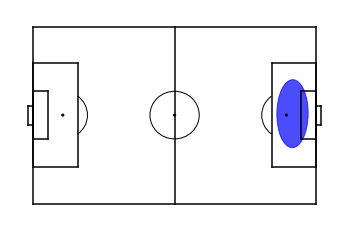

14
Counter({('clearance', True): 1})


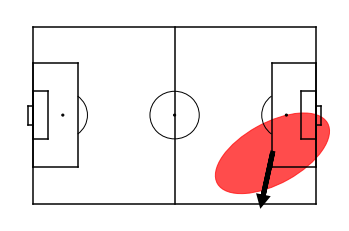

15
Counter({('out', True): 1})


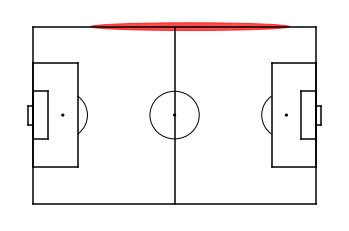

16
Counter({('pass', False): 2})


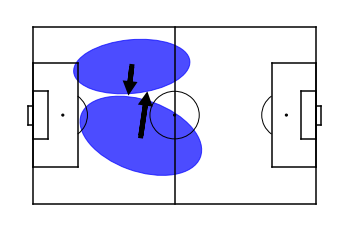

17
Counter({('owngoal', True): 1})


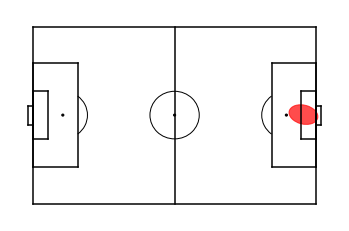

18
Counter({('out', False): 2, ('interception', True): 1})


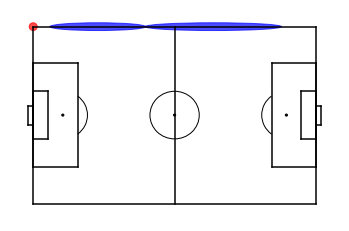

19
Counter({('shot', True): 1})


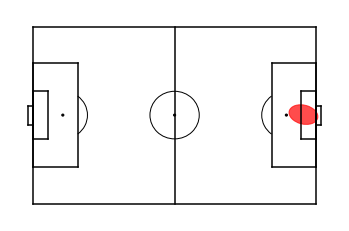

20
Counter({('receival', True): 1})


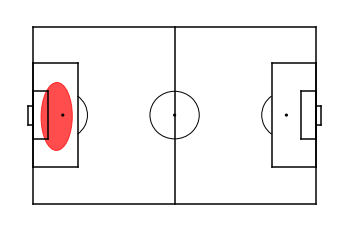

21
Counter({('freekick', True): 1})


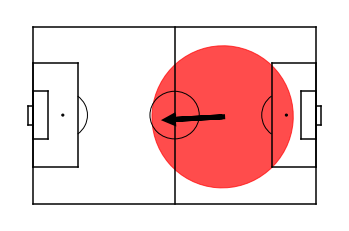

22
Counter({('clearance', True): 1})


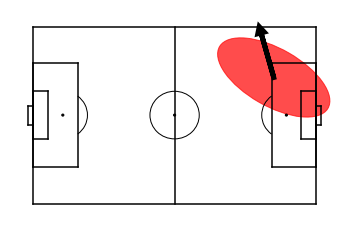

23
Counter({('foul', True): 1})


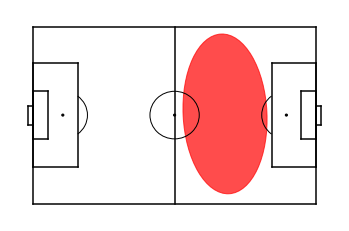

24
Counter({('freekick', False): 1})


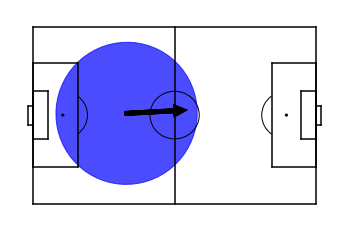

25
Counter({('owngoal', False): 1})


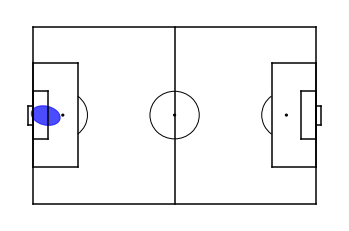

26
Counter({('dribble', False): 1})


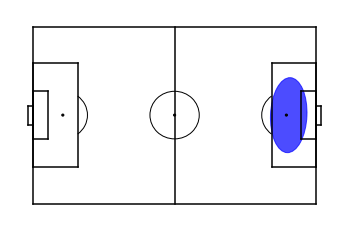

27
Counter({('out', False): 1})


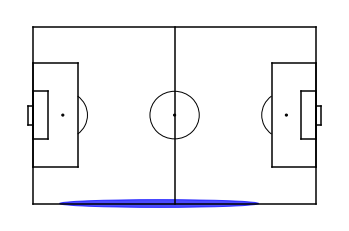

28
Counter({('interception', False): 1})


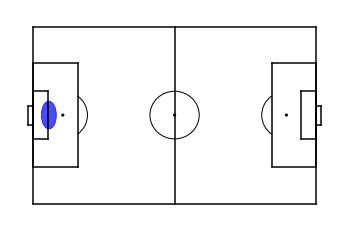

29
Counter({('goalkick', True): 1})


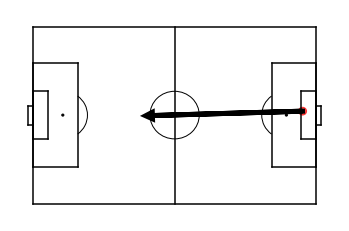

30
Counter({('clearance', False): 1})


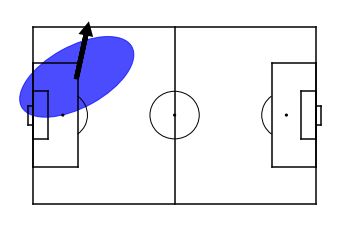

31
Counter({('freekick', False): 1})


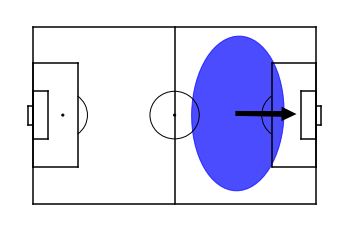

32
Counter({('shot', False): 1})


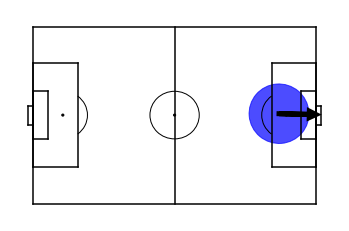

33
Counter({('out', False): 1})


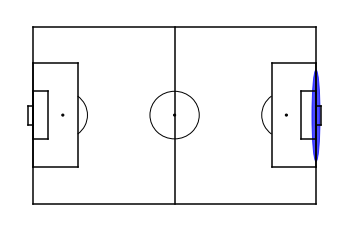

34
Counter({('shot', True): 1})


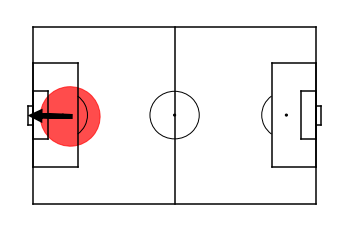

35
Counter({('foul', True): 1})


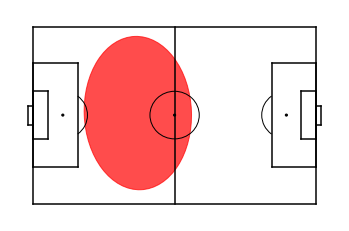

36
Counter({('throw_in', False): 1})


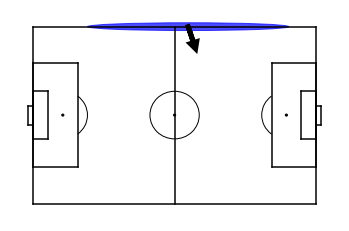

37
Counter({('goalkick', False): 1})


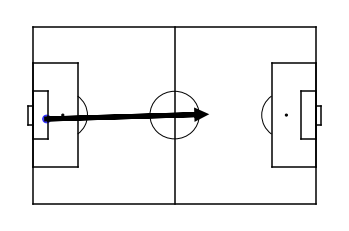

38
Counter({('throw_in', True): 1})


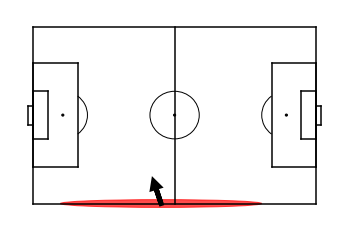

39
Counter({('shot', False): 1})


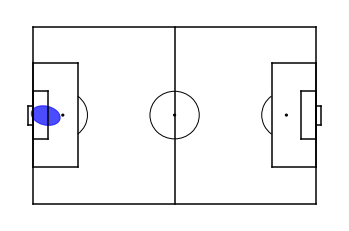

40
Counter({('throw_in', False): 1})


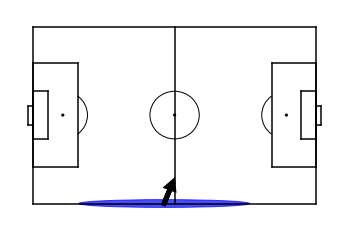

41
Counter({('pass', False): 1})


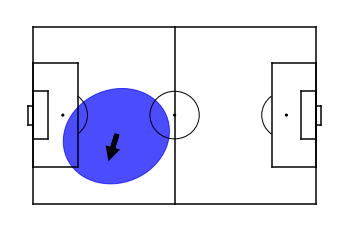

42
Counter({('freekick', True): 1})


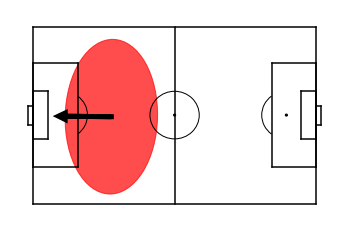

43
Counter({('interception', True): 1})


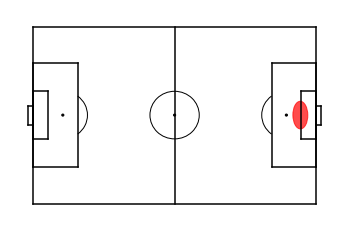

44
Counter({('pass', True): 1})


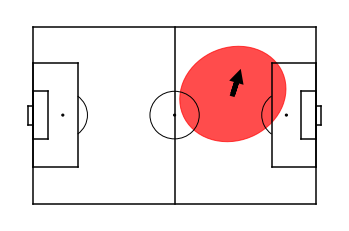

45
Counter({('foul', False): 1})


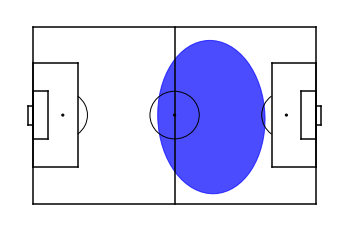

46
Counter({('throw_in', True): 1})


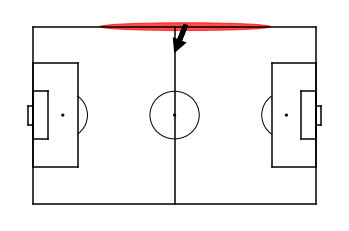

47
Counter({('foul', False): 1})


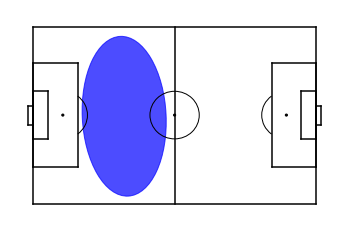

48
Counter({('clearance', False): 1})


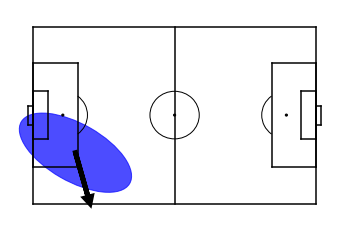

49
Counter({('interception', False): 1})


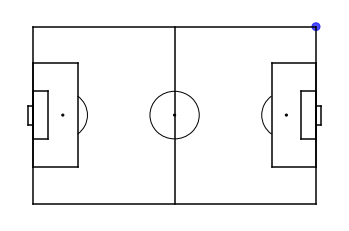

In [196]:
from collections import Counter

sim = (np.dot(forwardtrans,backwardtrans) + np.dot(backwardtrans,forwardtrans))/2

plt.matshow(sim)
plt.colorbar()
plt.show()

from sklearn.cluster import AgglomerativeClustering
nc = 50
clustering = AgglomerativeClustering(affinity="euclidean",linkage="average",n_clusters=nc).fit(sim.T)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clustering.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

interception 16 True


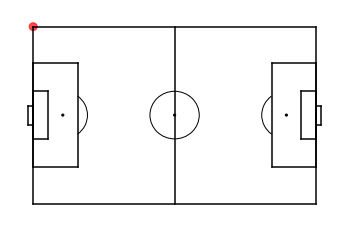

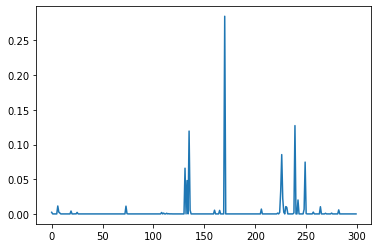

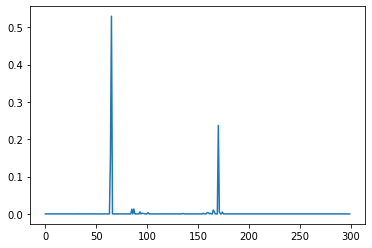

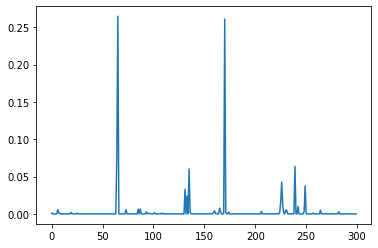

out 3 False


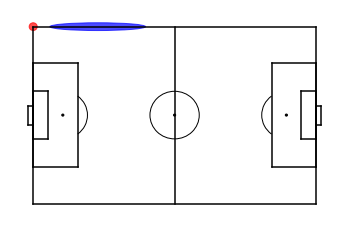

interception 16 True


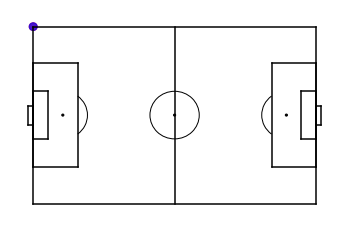

out 2 False


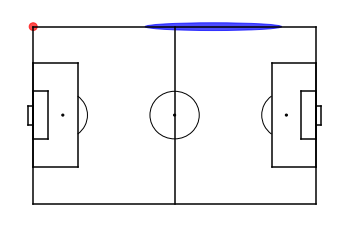

receival 6 True


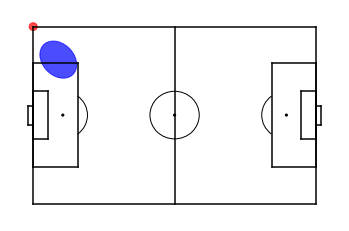

In [144]:
i = 170
ty,k = gmme._global_to_local(i % gmme.total_components())
is_opp = i > gmme.total_components() - 1
print(ty,k,is_opp)
vis.plot_component_w_arrow(gmme.models[ty],k,color="red",mirror=is_opp)

oldty,oldk,oldopp = ty,k,is_opp

v = np.zeros(gmme.total_components()*2)
v[i] = 1

forv = np.dot(np.dot(v,forwardtrans),backwardtrans)
plt.plot(forv)
plt.show()

backv = np.dot(np.dot(v,backwardtrans),forwardtrans)
plt.plot(backv)
plt.show()

newv = (forv + backv)/2
plt.plot(newv)
plt.show()

for j in np.argsort(newv)[::-1][:4]:
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    print(ty,k,is_opp)
    ax = vis.plot_component_w_arrow(gmme.models[oldty],oldk,color="red",mirror=oldopp,show=False)
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp)

In [ ]:
trans1 = ori_trans.copy()
for _i in range(10):
    print(trans1.sum())
    trans1 = np.dot(ori_trans.T,trans1)
    trans1 /= trans1.sum()

In [ ]:
delta_trans = trans1 - ori_trans
plt.matshow(delta_trans)
plt.colorbar()
plt.show
delta_trans.max(), delta_trans.min()

In [ ]:
trans = delta_trans
trans = trans1

In [ ]:
trans.sum()

In [ ]:
plt.hist([p for p,i,j in probs])
plt.show()

In [ ]:
probs = []
for i in range(len(trans)):
    for j in range(len(trans)):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs]# if i != j]

cols = list(ucprobas.columns)

def test(i,j):
    return True
    return "goal1" in cols[j]# and "opp" not in cols[j]
    return "shot" in cols[i] and "opp" not in cols[j]

interestmovs = [(p,i,j) for p,i,j in movs 
                if test(i,j)
                #"pass" not in cols[i]
                   # and "receival" not in cols[i]
                   # and "dribble" not in cols[i]
               ]

for p,i,j in interestmovs[:10]:
    print(p,i,j)
    print(cols[i],"(red)","->",cols[j],"(blue)")
    ax = mps.field(show=False)
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="red",mirror=is_opp,show=False)
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp,show=False)
    plt.show()

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 50:
        break

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 5:
        break